In [592]:
from matplotlib import pyplot as plt
import numpy as np
import pickle
import pandas as pd
import os
import json
import seaborn as sns
from itertools import chain
%matplotlib inline
%load_ext autoreload
%autoreload 2
from collections import Counter
from datetime import datetime, timedelta
import operator
import sys
from bisect import bisect_right, bisect, bisect_left
from scipy.stats import chisquare

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [593]:
all_ads_filename = '/dlabdata1/yazdania/so_jobs_data/all_ads.json'

In [594]:
all_ads = json.load(open(all_ads_filename, 'r'))

In [595]:
all_ads_list = list(all_ads.values())

In [596]:
all_ads_list[13]

{'id': 'http://stackoverflow.com/jobs/87575/senior-software-developer-oo-php-mysql-zend-world-first',
 'guidislink': True,
 'link': 'http://stackoverflow.com/jobs/87575/senior-software-developer-oo-php-mysql-zend-world-first',
 'links': [{'rel': 'alternate',
   'type': 'text/html',
   'href': 'http://stackoverflow.com/jobs/87575/senior-software-developer-oo-php-mysql-zend-world-first'}],
 'authors': [{'name': 'World First'}],
 'author_detail': {'name': 'World First'},
 'author': 'World First',
 'tags': [{'term': 'zend-framework', 'scheme': None, 'label': None},
  {'term': 'linux', 'scheme': None, 'label': None},
  {'term': 'domain-driven-design', 'scheme': None, 'label': None},
  {'term': 'soa', 'scheme': None, 'label': None},
  {'term': 'git', 'scheme': None, 'label': None}],
 'title': 'Senior Software Developer | OO, Php, MySql, ZEND at World First (London, UK)',
 'title_detail': {'type': 'text/plain',
  'language': None,
  'base': '',
  'value': 'Senior Software Developer | OO, Php,

## So how many ads do we have at each date?

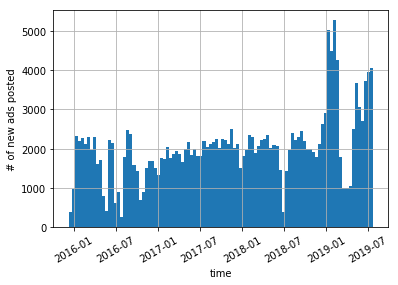

In [597]:
ad_times = pd.DataFrame([datetime(*x['published_parsed'][:-3]) for x in all_ads_list], 
                        columns=['published'])

ad_times.published.hist(bins=100)
plt.xticks(rotation=30)
plt.xlabel('time')
plt.ylabel('# of new ads posted')
plt.show()

## Generating a normalising dictionary

In [598]:
N_BINS = 20

In [599]:
def generate_end_date_list(starting_date, end_date, step_size=3):
    dates_list = list()
    current_point = starting_date

    while current_point < end_date:
        dates_list.append(current_point)
        current_point += timedelta(days=30*step_size)
    return dates_list

In [600]:
def generate_normalising_dict(dt_array, n_bins=N_BINS, start_point=np.datetime64('2016-01-01'), 
                                            end_point=np.datetime64('2019-08-01')):
    unix_epoch = np.datetime64(0, 's')
    one_second = np.timedelta64(1, 's')
    seconds_since_epoch = (dt_array - unix_epoch) / one_second
    dt_array = [datetime.utcfromtimestamp(x) for x in seconds_since_epoch]
    
    start_timestamp = (start_point - unix_epoch) / one_second
    end_timestamp = (end_point - unix_epoch) / one_second
    
    bins = np.linspace(start_timestamp, end_timestamp, num=n_bins)
    bins = [datetime.fromtimestamp(x) for x in bins]
    
    if len(dt_array) > 0:
        count = [len([x for x in dt_array if x >= bins[i] and x < bins[i+1]]) for i in range(len(bins)-1)]
    else:
        count = [0]*(len(bins)-1)
    return {bins[i]: count[i] for i in range(len(bins)-1)}

In [601]:
normalising_dict = generate_normalising_dict(ad_times.published.values)

In [602]:
normalising_dict

{datetime.datetime(2016, 1, 1, 1, 0): 11574,
 datetime.datetime(2016, 3, 9, 21, 12, 37, 894737): 8311,
 datetime.datetime(2016, 5, 17, 18, 25, 15, 789474): 6334,
 datetime.datetime(2016, 7, 25, 14, 37, 53, 684211): 9278,
 datetime.datetime(2016, 10, 2, 10, 50, 31, 578947): 6848,
 datetime.datetime(2016, 12, 10, 6, 3, 9, 473684): 8728,
 datetime.datetime(2017, 2, 17, 2, 15, 47, 368421): 9434,
 datetime.datetime(2017, 4, 26, 23, 28, 25, 263158): 10098,
 datetime.datetime(2017, 7, 4, 19, 41, 3, 157895): 10898,
 datetime.datetime(2017, 9, 11, 15, 53, 41, 52632): 11733,
 datetime.datetime(2017, 11, 19, 11, 6, 18, 947368): 9945,
 datetime.datetime(2018, 1, 27, 7, 18, 56, 842105): 11406,
 datetime.datetime(2018, 4, 6, 4, 31, 34, 736842): 11001,
 datetime.datetime(2018, 6, 14, 0, 44, 12, 631579): 8234,
 datetime.datetime(2018, 8, 21, 20, 56, 50, 526316): 11269,
 datetime.datetime(2018, 10, 29, 16, 9, 28, 421053): 11953,
 datetime.datetime(2019, 1, 6, 12, 22, 6, 315789): 20575,
 datetime.dateti

## Creating a tags dataframe

Not every ad has tags, hence why we have to explicitly make sure we only keep those that do for this dataframe.

In [603]:
sys.path.insert(0, '/home/yazdania/so_jobs_analysis/')
from utilities.text_utils import create_entity_item_bags, load_SO_tags

def get_date_and_tag_df(all_ads_list, use_summaries=True, tags_map=None, forbidden_subtags=None, n_grams=None):
    date_and_tag_df = pd.DataFrame([[datetime(*x['published_parsed'][:-3]), y['term'], x['author']] 
                                for x in all_ads_list if 'tags' in x for y in x['tags']], 
                               columns=['published', 'tag', 'author'])
    if use_summaries:
        date_and_summary_df = pd.DataFrame([[datetime(*x['published_parsed'][:-3]), x['summary'], x['author']] 
                                for x in all_ads_list], 
                               columns=['published', 'summary', 'author'])
        create_entity_item_bags(date_and_summary_df, tags_map, forbidden_subtags, n_grams, 'summary', do_stem=True)
        summary_tags = date_and_summary_df.\
            set_index(['published', 'author']).summary_tags.apply(pd.Series).stack().reset_index().\
            rename(columns={0:'tag'}).drop(columns=['level_2'])
        date_and_tag_df = pd.concat([date_and_tag_df, summary_tags],sort=True)
    
    return date_and_tag_df

In [604]:
tags_filename = '/home/yazdania/so_jobs_analysis/tags_all.csv'
tags_with_counts = pd.read_csv(tags_filename).drop(columns=['Unnamed: 0'])
tags_with_counts['CreationDate'] = pd.to_datetime(tags_with_counts['CreationDate'])
synonyms_filename = '/dlabdata1/yazdania/trends_udemy/so_tag_synonyms/synonym_dict.json'
so_tags,_,_ = load_SO_tags(tags_filename, remove_textless=False, synonym_filename=synonyms_filename, do_stem=True)
forbidden_map = json.load(open('/home/yazdania/udemy_and_trend_crawler/unrelated_subtag_map.json'))

{2: 19190, 1: 30215, 3: 5019, 4: 529, 5: 32}


In [605]:
tag_only_tags = get_date_and_tag_df(all_ads_list, use_summaries=False)

In [606]:
len(set(tag_only_tags.loc[tag_only_tags.published >= datetime(2016,10,1), 'tag'].unique()).\
                difference(
set(tag_only_tags.loc[tag_only_tags.published < datetime(2016,10,1), 'tag'].unique())
))

3590

In [607]:
#date_and_tag_df.shape

In [608]:
# t1 = datetime.now()
# date_and_tag_df = get_date_and_tag_df(all_ads_list[:1000], True, so_tags, forbidden_map, 5)
# print((datetime.now()-t1).total_seconds())

In [609]:
#date_and_tag_df.sort_values('author')

In [610]:
t1 = datetime.now()
date_and_tag_df = get_date_and_tag_df(all_ads_list, True, so_tags, forbidden_map, 5)
print((datetime.now()-t1).total_seconds())

4880.158663


In [611]:
date_and_tag_df.head()

author           published     tag
0  Level 3 Communications 2016-01-01 20:14:11    unix
1  Level 3 Communications 2016-01-01 20:14:11   linux
2  Level 3 Communications 2016-01-01 20:14:11  oracle
3  Level 3 Communications 2016-01-01 20:14:11     dns
4  Level 3 Communications 2016-01-01 20:14:11  tcp-ip

In [612]:
len(all_ads_list)

205458

In [613]:
date_and_tag_df.shape

(22353373, 3)

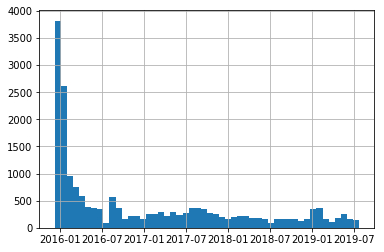

In [614]:
new_tags_df = date_and_tag_df[['tag','published']].groupby('tag').min()
new_tags_df.published.hist(bins=50)

In [615]:
top_freq = date_and_tag_df.groupby('tag').count().sort_values('published', ascending=False).\
                        reset_index().rename(columns={'published':'total_freq'}).head(500)
top_freq_tags = top_freq.tag.values

In [616]:
top_freq_tags[:100]

array(['product', 'designer', 'having', 'applicative', 'managed', 'build',
       's', 'testing', 'new-operator', 'performance', 'uses', 'system',
       'this', 'service', 'required', 'responsibility', 'solution', 'web',
       'customer', 'java', 'include', 'projection', 'provider',
       'javascript', 'tooling', 'communicator', 'environ', 'processing',
       'implementation', 'platform', 'agile', 'lead', 'architecture',
       'integrator', 'dos', 'makefile', 'security', 'cloud', 'can-bus',
       'roles', 'collaboration', 'client', 'innovation', 'parted',
       'automic', 'continue', 'computability', 'll', 'maintainability',
       'jobs', 'python', 'r', 'position', 'join', 'der', 'sql', 'des',
       'intern', 'deploying', 'time', 'relation', 'base', 'networking',
       'infrastructure', 'mobility', 'operational', 'take', 'database',
       'frameworks', 'amazon-web-services', 'complexity-theory',
       'planning', 'function', 'excel', 'featured', 'die', 'degrees',
       're

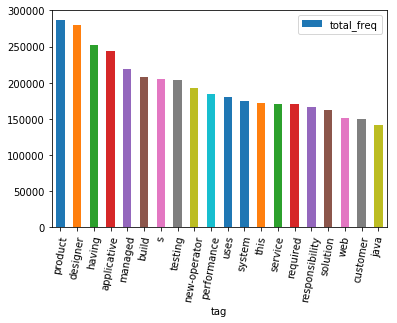

In [617]:
top_freq.head(20).plot(x='tag', y='total_freq', kind='bar')
plt.xticks(rotation=80)
plt.show()

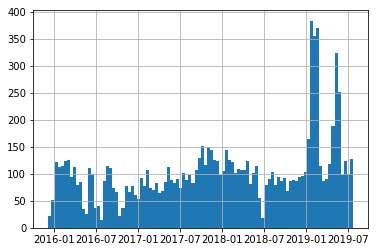

In [618]:
date_and_tag_df.loc[date_and_tag_df.tag=='sysadmin', 'published'].hist(bins=100)

## Looking at tag frequency and normalised frequency histograms

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
def get_time_histogram(dt_array, n_bins=N_BINS, start_point=np.datetime64('2016-01-01'), 
                                            end_point=np.datetime64('2019-08-01')):
    unix_epoch = np.datetime64(0, 's')
    one_second = np.timedelta64(1, 's')
    seconds_since_epoch = (dt_array - unix_epoch) / one_second
    dt_array = [datetime.utcfromtimestamp(x) for x in seconds_since_epoch]
    
    start_timestamp = (start_point - unix_epoch) / one_second
    end_timestamp = (end_point - unix_epoch) / one_second
    
    bins = np.linspace(start_timestamp, end_timestamp, num=n_bins)
    bins = [datetime.fromtimestamp(x) for x in bins]
    
    if len(dt_array) > 0:
        count = [len([x for x in dt_array if x >= bins[i] and x < bins[i+1]]) for i in range(len(bins)-1)]
    else:
        count = [0]*(len(bins)-1)
    return pd.DataFrame({'hist_count': count, 'date': bins[:-1]})

def normalise_time_hist(hist_data, normalising_dict, col_name='hist_count', norm='lin'):
    if norm == 'none':
        return hist_data
    time_range = sorted(normalising_dict.keys())
    hist_data['normaliser'] = hist_data['date'].apply(lambda x: 
                              normalising_dict[time_range[bisect_right(time_range, x)-1]])
    if norm == 'log':
        hist_data[col_name+'_norm'] = hist_data.apply(lambda x: x[col_name] / np.log(x['normaliser']), axis=1)
    else:
        hist_data[col_name+'_norm'] = hist_data.apply(lambda x: x[col_name] / x['normaliser'], axis=1)
    hist_data['date'] = pd.to_datetime(hist_data['date'])
    return hist_data

def calculate_deltas(hist_data, col_name, method='reg', reg_length=3, normaliser_term=10):
    assert method in ['rel', 'reg', 'abs'] and reg_length > 1
    hist_data = hist_data.sort_values('date')
    dates = hist_data['date'].values
    values = hist_data[col_name].values
    if method == 'reg':
        slope_list = list()
        for i in range(reg_length, len(values)+1):
            x = np.array(list(range(reg_length))).reshape((reg_length, 1))
            y = np.array(values[i-reg_length:i])
            reg_model = LinearRegression()
            reg_model.fit(x, y)
            if method == 'abs':
                slope_list.append(reg_model.coef_[0])
            else:
                denom = 0.1*np.mean(values[:i])+0.9*np.mean(y[:-1])+normaliser_term
                slope_list.append(reg_model.coef_[0]/denom)
        return pd.DataFrame({'slope': slope_list, 'date': dates[reg_length-1:]})
    else:
        deltas = list()
        for i in range(1, len(values)):
            if method == 'rel':
                deltas.append((values[i] - values[i-1])/
                                  (normaliser_term+
                                   np.mean(values[:i])))
            else:
                deltas.append((values[i] - values[i-1]))
        return pd.DataFrame({'slope': deltas, 'date': dates[1:]})

In [33]:
def plot_hist_from_df(hist_df, y_col='hist_count_norm'):
    hist_df.plot(x='date', y=y_col, kind='bar', color='blue', legend=False, width=0.7)
    ax=plt.gca()
    ax.set_xticklabels([dt.strftime('%Y-%m-%d') for dt in hist_df.date])
    for i, tick in enumerate(ax.xaxis.get_major_ticks()):
        if (i % 4 != 0): # 24 hours * 7 days = 1 week
            tick.set_visible(False)
    plt.xticks(rotation=45)
    plt.show()

In [34]:
def visualise_hist_df(date_and_tag_df, tag, bins=N_BINS, norm='log'):
    if tag is not None:
        hist_df = normalise_time_hist(get_time_histogram(
            date_and_tag_df.loc[date_and_tag_df.tag==tag, 'published'], bins), 
                        normalising_dict, norm=norm)
    else:
        hist_df = normalise_time_hist(get_time_histogram(
            date_and_tag_df['published'], bins), 
                        normalising_dict, norm=norm)
        
    if norm == 'none':
        plot_hist_from_df(hist_df, 'hist_count')
    else:
        plot_hist_from_df(hist_df)

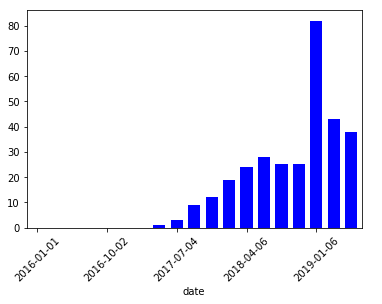

In [35]:
visualise_hist_df(date_and_tag_df, 'pytorch', norm='none')

In [36]:
def add_tag_name(df, tag_name):
    df['tag'] = tag_name
    return df

## Finding the greatest deltas

In [36]:
def calculate_all_deltas(date_and_tag_df, top_freq_tags, normalising_dict):
    df_list = []
    counter = 0
    for tag in top_freq_tags:
        df_list.append(add_tag_name(calculate_deltas(normalise_time_hist(get_time_histogram(
        date_and_tag_df.loc[date_and_tag_df.tag==tag, 'published']), 
                        normalising_dict, norm='log'), 'hist_count_norm', method='reg'), tag))
        counter += 1
        if counter % 10 == 0:
            print(counter)

    all_deltas_df = pd.concat(df_list).reset_index().drop('index', axis=1)
    return all_deltas_df

In [ ]:
all_deltas_df = calculate_all_deltas(date_and_tag_df, top_freq_tags, normalising_dict)

In [1209]:
all_deltas_df.describe()

slope
count  8500.000000
mean      0.059419
std       0.244063
min      -0.934612
25%      -0.058476
50%       0.037124
75%       0.145823
max       4.680823

In [1210]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(all_deltas_df.loc[all_deltas_df['slope'] >= all_deltas_df['slope'].quantile(0.98)].\
            sort_values(['tag', 'date']))

slope                       date                      tag
3023  0.942712 2019-01-06 12:22:06.315789                   access
6440  0.765111 2019-01-06 12:22:06.315789                  account
5063  1.031516 2019-01-06 12:22:06.315789                      act
4060  1.443882 2019-01-06 12:22:06.315789                   action
7103  1.010686 2019-01-06 12:22:06.315789                      add
4706  1.012037 2019-01-06 12:22:06.315789                 addition
4179  1.047232 2019-01-06 12:22:06.315789           administration
4230  1.220294 2019-01-06 12:22:06.315789                   amazon
3108  0.679027 2019-01-06 12:22:06.315789               analytical
1816  1.050210 2019-01-06 12:22:06.315789                analytics
3771  0.634353 2019-01-06 12:22:06.315789             apache-spark
286   0.664744 2019-01-06 12:22:06.315789              application
456   0.616249 2019-01-06 12:22:06.315789             architecture
1493  0.773239 2019-01-06 12:22:06.315789                     area
5080  0.913087 2019-01-06 12:22:06.315789  artificial-intelligence
6966  0.928076 2018-10-29 16:09:28.421053            authorization
6967  4.680823 2019-01-06 12:22:06.315789            authorization
949   0.627594 2019-01-06 12:22:06.315789               automation
2479  1.381664 2019-01-06 12:22:06.315789                    azure
4026  1.380287 2019-01-06 12:22:06.315789                    basic
3363  0.756715 2019-01-06 12:22:06.315789                    basis
7290  0.767487 2019-01-06 12:22:06.315789                 capacity
5097  0.748867 2019-01-06 12:22:06.315789                   center
405   2.078441 2019-01-06 12:22:06.315789                   client
235   1.346783 2019-01-06 12:22:06.315789                    cloud
2666  0.893968 2019-01-06 12:22:06.315789            collaborative
3601  1.620750 2019-01-06 12:22:06.315789                   colors
805   0.675516 2017-07-04 19:41:03.157895            communication
813   0.668373 2019-01-06 12:22:06.315789            communication
4298  1.373714 2019-01-06 12:22:06.315789                 complete
907   1.027149 2017-07-04 19:41:03.157895         computer-science
908   0.647483 2017-09-11 15:53:41.052632         computer-science
3142  0.976009 2019-01-06 12:22:06.315789            configuration
3552  0.902527 2019-05-24 05:47:22.105263                 contacts
6661  0.964442 2019-01-06 12:22:06.315789                 contract
1884  0.691374 2019-01-06 12:22:06.315789                 controls
6916  0.645539 2019-01-06 12:22:06.315789              coordinates
8072  0.639452 2019-01-06 12:22:06.315789           data-warehouse
609   0.619611 2019-01-06 12:22:06.315789                 database
6950  1.282383 2019-01-06 12:22:06.315789                      del
6951  0.888717 2019-03-16 08:34:44.210526                      del
6952  3.156065 2019-05-24 05:47:22.105263                      del
2500  0.631084 2016-07-25 14:37:53.684211                      des
6287  0.799178 2019-01-06 12:22:06.315789                  desktop
7001  0.712506 2019-01-06 12:22:06.315789               difference
1136  0.903394 2019-01-06 12:22:06.315789                  digital
4383  0.911187 2019-01-06 12:22:06.315789                direction
2870  1.657851 2019-01-06 12:22:06.315789               disability
2972  0.748680 2019-01-06 12:22:06.315789                 document
2445  0.686352 2019-01-06 12:22:06.315789            documentation
4774  2.769569 2019-01-06 12:22:06.315789                       el
4775  1.357051 2019-03-16 08:34:44.210526                       el
4776  3.418453 2019-05-24 05:47:22.105263                       el
1357  1.058142 2019-01-06 12:22:06.315789               enterprise
218   0.696325 2019-01-06 12:22:06.315789              environment
2496  1.332462 2019-01-06 12:22:06.315789                   equals
2080  0.916509 2017-07-04 19:41:03.157895               equivalent
2081  0.649589 2017-09-11 15:53:41.052632               equivalent
6015  0.766530 2019-01-06 12:22:06.315789               

In [992]:
all_deltas_df.loc[all_deltas_df.tag == 'bootstrap']

slope                       date        tag
5168 -3.117237e-02 2016-05-17 18:25:15.789474  bootstrap
5169 -5.592507e-02 2016-07-25 14:37:53.684211  bootstrap
5170  2.918812e-02 2016-10-02 10:50:31.578947  bootstrap
5171  3.793307e-02 2016-12-10 06:03:09.473684  bootstrap
5172  1.722625e-03 2017-02-17 02:15:47.368421  bootstrap
5173 -2.384666e-02 2017-04-26 23:28:25.263158  bootstrap
5174  7.747391e-03 2017-07-04 19:41:03.157895  bootstrap
5175 -5.466741e-02 2017-09-11 15:53:41.052632  bootstrap
5176 -8.498722e-02 2017-11-19 11:06:18.947368  bootstrap
5177 -2.032197e-02 2018-01-27 07:18:56.842105  bootstrap
5178 -1.055657e-02 2018-04-06 04:31:34.736842  bootstrap
5179 -5.256071e-03 2018-06-14 00:44:12.631579  bootstrap
5180  0.000000e+00 2018-08-21 20:56:50.526316  bootstrap
5181  0.000000e+00 2018-10-29 16:09:28.421053  bootstrap
5182  2.986381e-02 2019-01-06 12:22:06.315789  bootstrap
5183 -3.781518e-18 2019-03-16 08:34:44.210526  bootstrap
5184 -1.913606e-02 2019-05-24 05:47:22.105263  bootstrap

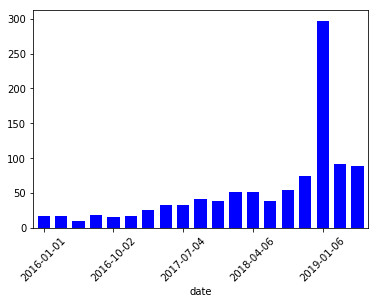

In [993]:
visualise_hist_df(date_and_tag_df,'cloud', norm='log')

## Investigating the two spikes and the period before them

In [38]:
def get_ads_time_subset(all_ads, start_date, end_date):
    return [ad for ad in all_ads if datetime(*ad['published_parsed'][:-3]) >= start_date and 
                                    datetime(*ad['published_parsed'][:-3]) < end_date]

def get_ads_company_subset(all_ads, companies_list):
    return [ad for ad in all_ads if ad['author'] in companies_list]

def get_all_companies(ad_list):
    return [ad['author'] for ad in ad_list]

def get_list_diff(list_1, list_2):
    return set(list_1).difference(set(list_2)), set(list_2).difference(set(list_1))


In [39]:
ads_spike_1 = get_ads_time_subset(all_ads_list, datetime(2019,1,1), datetime(2019,3,15))
ads_spike_2 = get_ads_time_subset(all_ads_list, datetime(2019,4,1), datetime(2019,7,15))

In [40]:
ads_before_spike_1 = get_ads_time_subset(all_ads_list, datetime(2016,1,1), datetime(2019,1,1))
ads_before_spike_2 = get_ads_time_subset(all_ads_list, datetime(2016,1,1), datetime(2019,4,1))
ads_right_before_spike_1 = get_ads_time_subset(all_ads_list, datetime(2018,9,15), datetime(2019,1,1))

Total number of unique companies on the platform since the beginning of our dataset.

In [41]:
len(set(get_all_companies(all_ads_list)))

23909

23909

### Visualisations of the top 40 companies in terms of total number of ads in each of the time periods selected

In [42]:
publishers_new_ads = pd.DataFrame([[datetime(*ad['published_parsed'][:-3]), ad['author']] for ad in ads_spike_1], 
                                  columns=['date', 'author'])

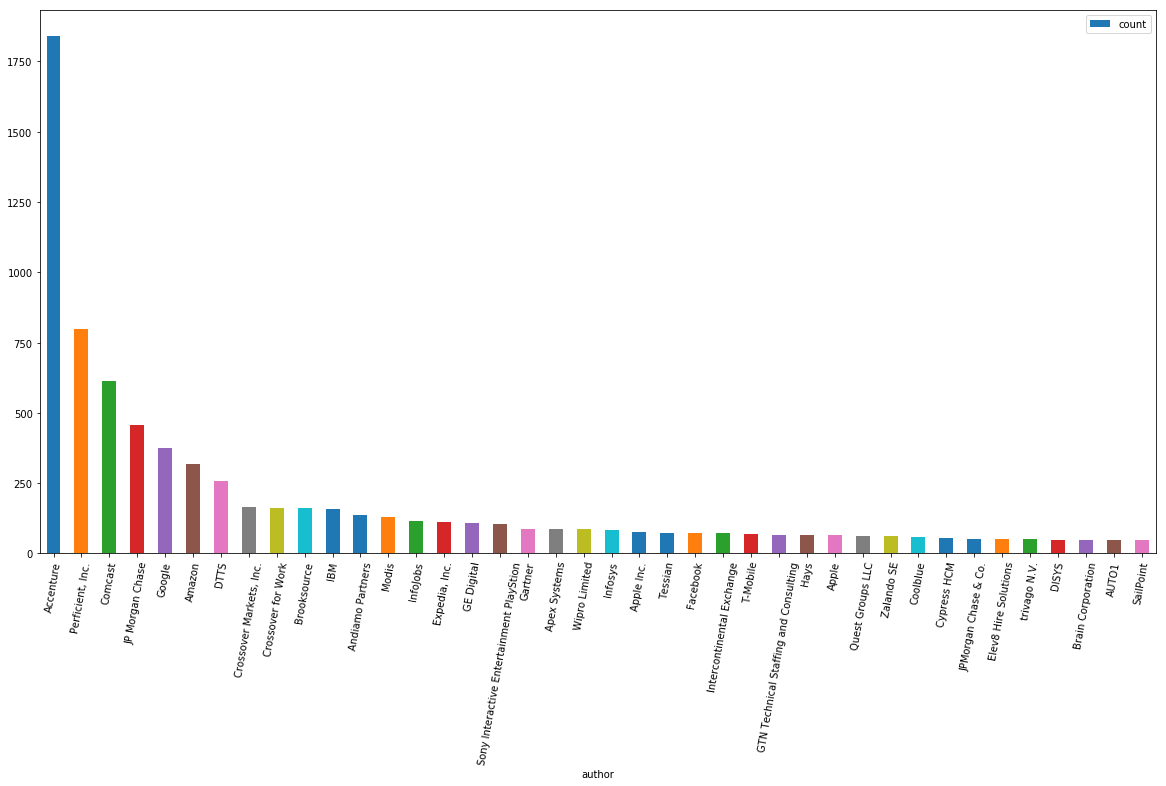

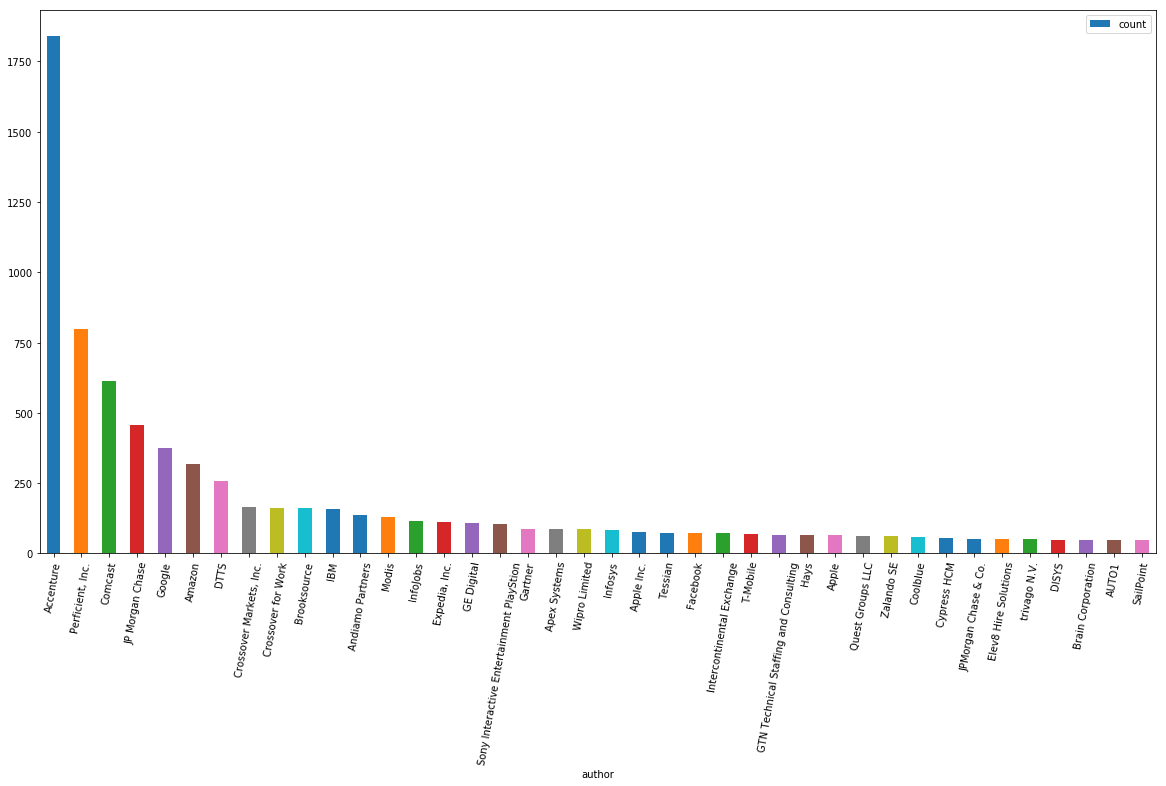

In [43]:
author_counts = publishers_new_ads.groupby('author').count().reset_index().rename(columns={'date':'count'}).\
                                                                            sort_values('count', ascending=False)
author_counts.head(40).plot(x='author', y='count', kind='bar', figsize=(20,10))
plt.xticks(rotation=80)
plt.show()

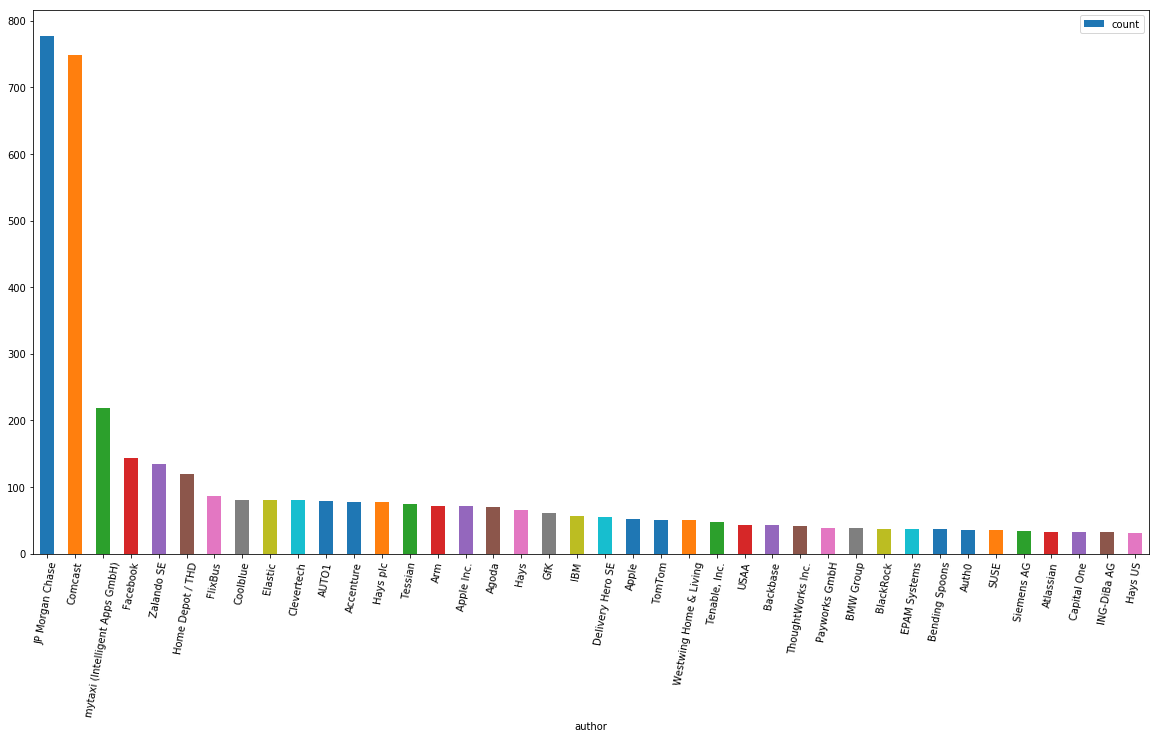

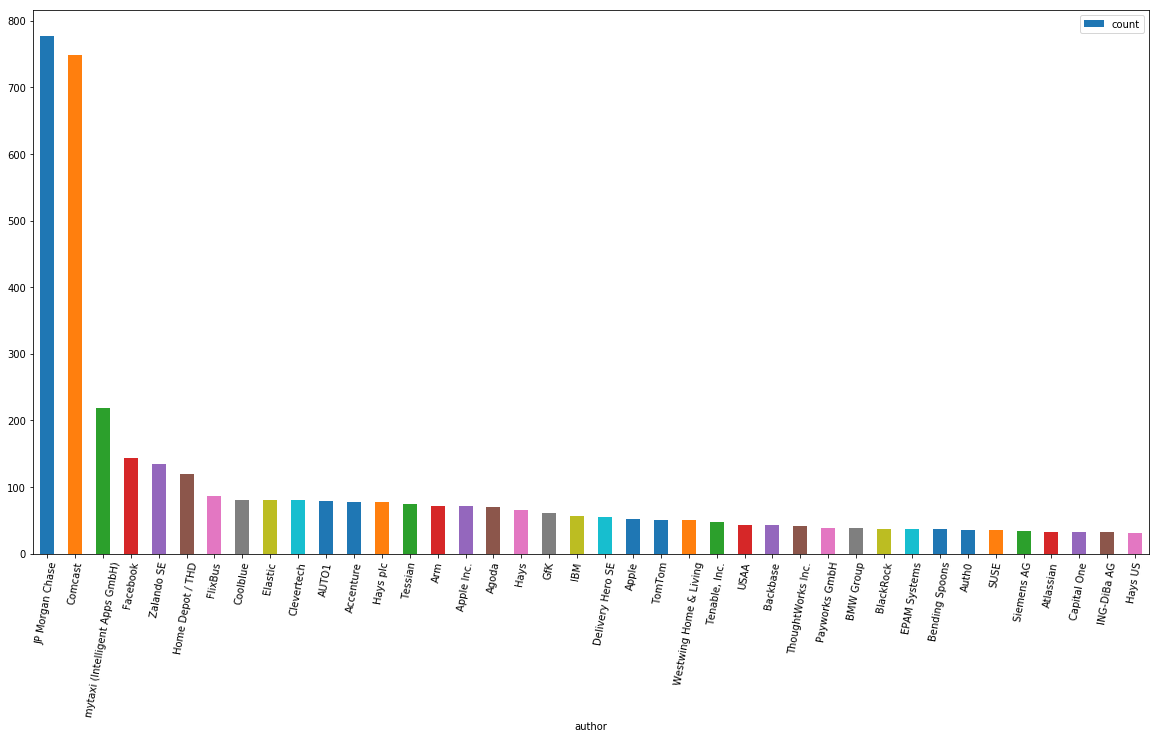

In [44]:
publishers_new_ads = pd.DataFrame([[datetime(*ad['published_parsed'][:-3]), ad['author']] for ad in 
                                   ads_right_before_spike_1], 
                                  columns=['date', 'author'])
author_counts = publishers_new_ads.groupby('author').count().reset_index().rename(columns={'date':'count'}).\
                                                                            sort_values('count', ascending=False)
author_counts.head(40).plot(x='author', y='count', kind='bar', figsize=(20,10))
plt.xticks(rotation=80)
plt.show()

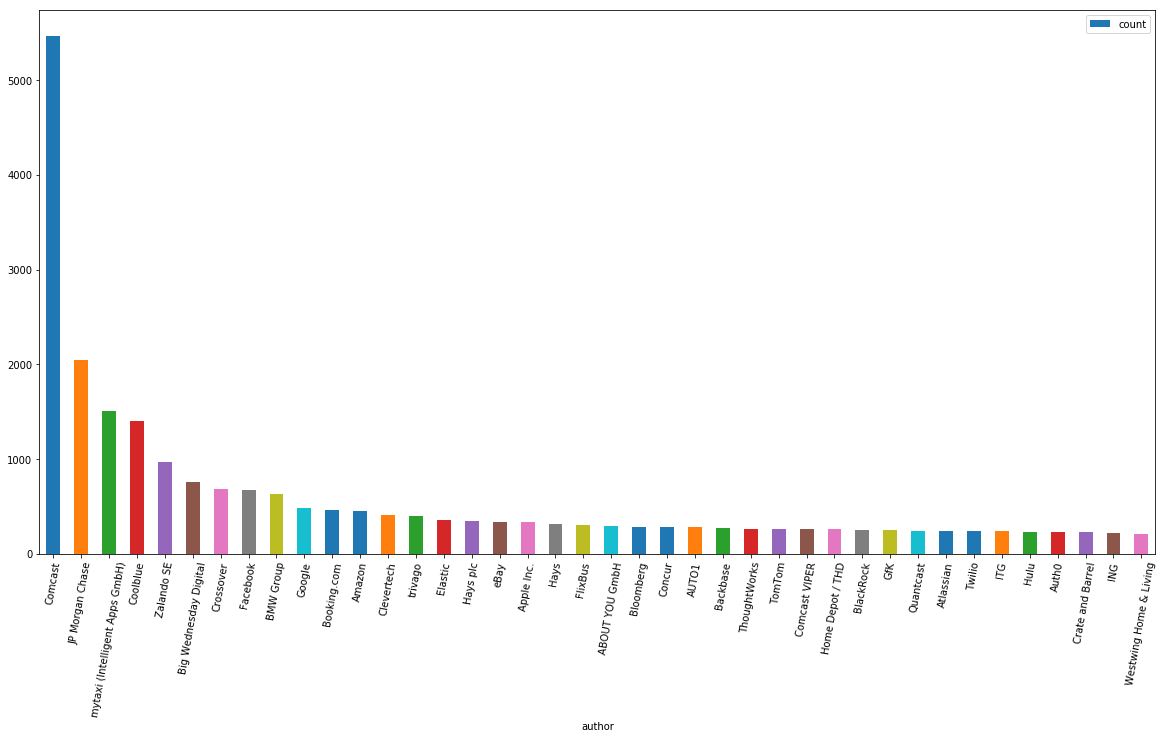

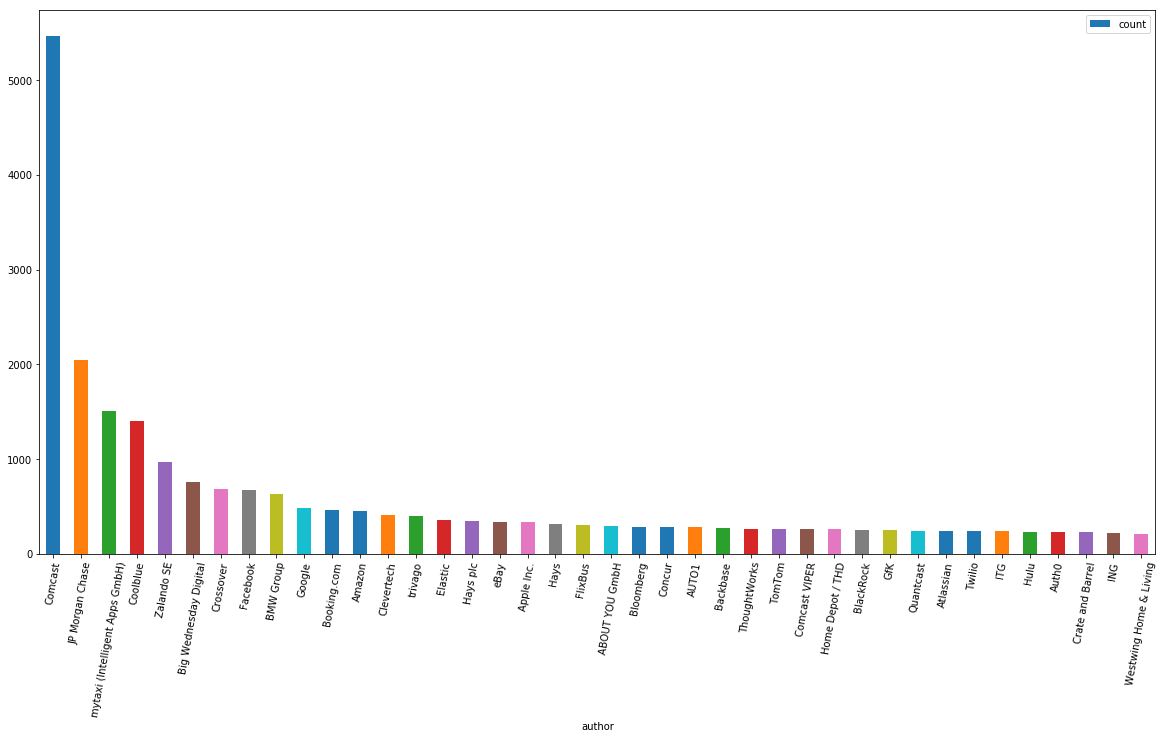

In [45]:
publishers_new_ads = pd.DataFrame([[datetime(*ad['published_parsed'][:-3]), ad['author']] for ad in 
                                   ads_before_spike_1], 
                                  columns=['date', 'author'])
author_counts = publishers_new_ads.groupby('author').count().reset_index().rename(columns={'date':'count'}).\
                                                                            sort_values('count', ascending=False)
author_counts.head(40).plot(x='author', y='count', kind='bar', figsize=(20,10))
plt.xticks(rotation=80)
plt.show()

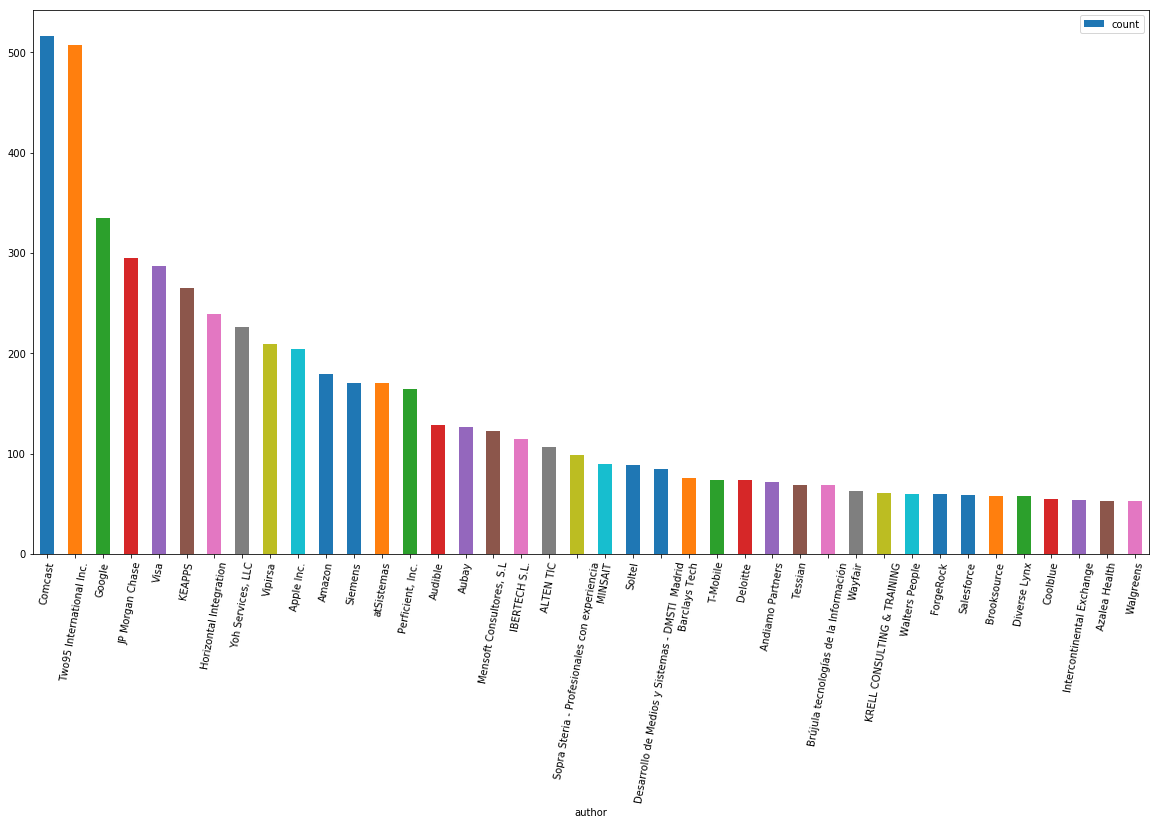

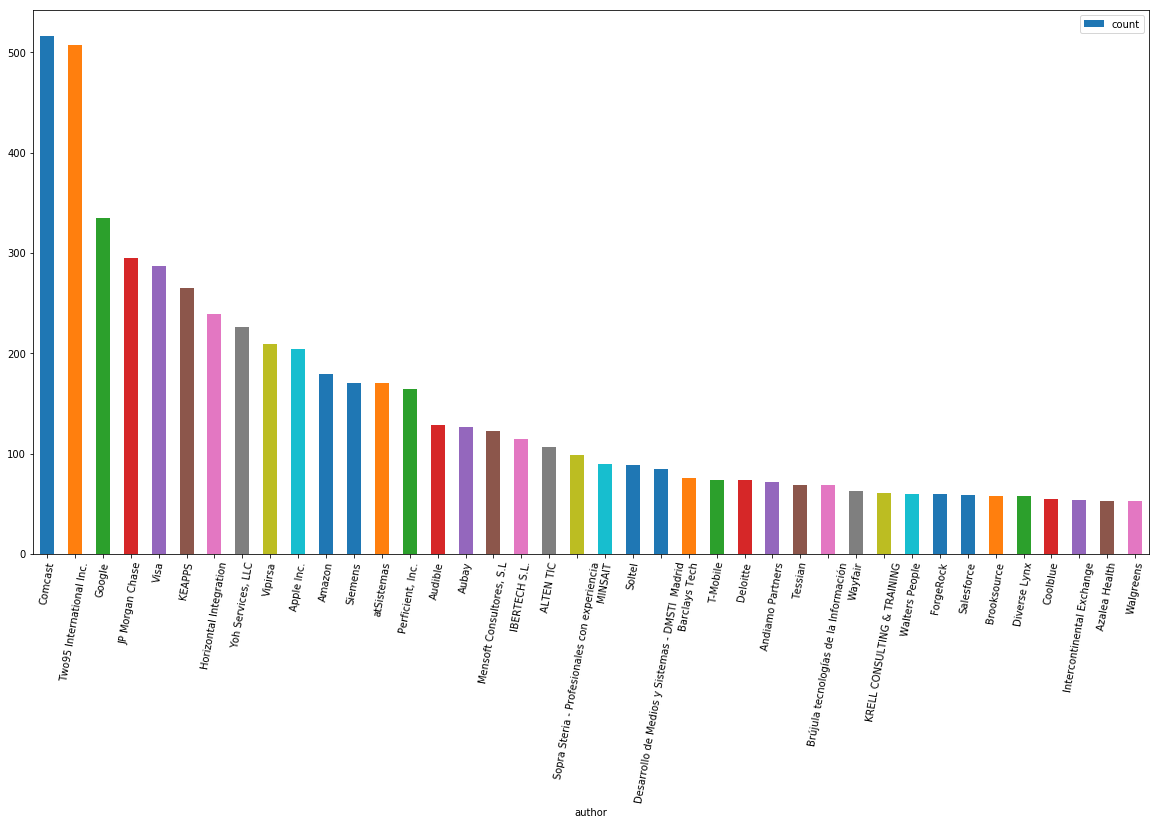

In [46]:
publishers_new_ads = pd.DataFrame([[datetime(*ad['published_parsed'][:-3]), ad['author']] for ad in 
                                   ads_spike_2], 
                                  columns=['date', 'author'])
author_counts = publishers_new_ads.groupby('author').count().reset_index().rename(columns={'date':'count'}).\
                                                                            sort_values('count', ascending=False)
author_counts.head(40).plot(x='author', y='count', kind='bar', figsize=(20,10))
plt.xticks(rotation=80)
plt.show()

In [47]:
from random import sample
sample([x['title'] for x in ads_spike_1 if x['author'] == 'Accenture'], 10)

['Oracle Cloud Big Data Solution Architect at Accenture (Houston, TX)',
 'E&G Software Innovation Specialist at Accenture (Atlanta, GA)',
 'Oracle Cloud Supply Chain Implementation Specialist at Accenture (Philadelphia, PA)',
 'Automation Engineer - Tosca or Worksoft at Accenture (Miami, FL)',
 'Azure Big Data Solution Architect at Accenture (Philadelphia, PA)',
 'Azure Big Data Engineer at Accenture (Philadelphia, PA)',
 'Accenture DayNine - Workday Integrations Senior Analyst at Accenture (Philadelphia, PA)',
 'AWS Big Data Engineer at Accenture (Atlanta, GA)',
 'Oracle Cloud Big Data Solution Architect at Accenture (Houston, TX)',
 'Angular Developer at Accenture (Phoenix, AZ)']

['Oracle Cloud Big Data Solution Architect at Accenture (Houston, TX)',
 'E&G Software Innovation Specialist at Accenture (Atlanta, GA)',
 'Oracle Cloud Supply Chain Implementation Specialist at Accenture (Philadelphia, PA)',
 'Automation Engineer - Tosca or Worksoft at Accenture (Miami, FL)',
 'Azure Big Data Solution Architect at Accenture (Philadelphia, PA)',
 'Azure Big Data Engineer at Accenture (Philadelphia, PA)',
 'Accenture DayNine - Workday Integrations Senior Analyst at Accenture (Philadelphia, PA)',
 'AWS Big Data Engineer at Accenture (Atlanta, GA)',
 'Oracle Cloud Big Data Solution Architect at Accenture (Houston, TX)',
 'Angular Developer at Accenture (Phoenix, AZ)']

In [48]:
sample([x['title'] for x in ads_before_spike_1 if x['author'] == 'Comcast'], 10)

['Software Dev & Engineering - Java at Comcast (Washington, DC)',
 'Senior SQL Developer & Analyst at Comcast (Philadelphia, PA)',
 'Support Engineer at Comcast (New York, NY)',
 'Principal Engineer at Comcast (Sunnyvale, CA)',
 'Eng 4, Product Development Engineering at Comcast (Mount Laurel, NJ)',
 'Eng 2, Engineering Ops at Comcast (Philadelphia, PA)',
 'Engineer 4, Software Dev & Eng (SDET) at Comcast (Philadelphia, PA)',
 'Sr. Manager, Core Mobile Applications at Comcast (Philadelphia, PA)',
 'Senior Software Engineer, Mobile & HTML5 at Comcast (New York, NY)',
 'TAPS Specialist - Advanced Software Support at Comcast (Chicago, IL)']

['Software Dev & Engineering - Java at Comcast (Washington, DC)',
 'Senior SQL Developer & Analyst at Comcast (Philadelphia, PA)',
 'Support Engineer at Comcast (New York, NY)',
 'Principal Engineer at Comcast (Sunnyvale, CA)',
 'Eng 4, Product Development Engineering at Comcast (Mount Laurel, NJ)',
 'Eng 2, Engineering Ops at Comcast (Philadelphia, PA)',
 'Engineer 4, Software Dev & Eng (SDET) at Comcast (Philadelphia, PA)',
 'Sr. Manager, Core Mobile Applications at Comcast (Philadelphia, PA)',
 'Senior Software Engineer, Mobile & HTML5 at Comcast (New York, NY)',
 'TAPS Specialist - Advanced Software Support at Comcast (Chicago, IL)']

In [49]:
sample([x['title'] for x in ads_spike_2 if x['author'] == 'Two95 International Inc.'], 10)

['# Java Developer - Philadelphia, PA at Two95 International Inc. (Philadelphia, PA)',
 'Senior Java Developer - West Coast Or Texas Or Oklahoma - Rate Open at Two95 International Inc. (Austin, TX)',
 'Senior Consultant (IIB) at Two95 International Inc. (Fort Worth, TX)',
 '#Salesforce Architect - Center City, Philadelphia at Two95 International Inc. (Philadelphia, PA)',
 'Salesforce Architect - Center City, Philadelphia at Two95 International Inc. (Philadelphia, PA)',
 'Senior Consultant (IIB) at Two95 International Inc. (Fort Worth, TX)',
 '.Net Developer with Angular at Two95 International Inc. (Philadelphia, PA)',
 'Java Engineer at Two95 International Inc. (Philadelphia, PA)',
 'Sr. Software Engineer (.Net) - Atlanta, GA at Two95 International Inc. (Atlanta, GA)',
 'Lead (.Net) Consultant/Architect at Two95 International Inc. (Atlanta, GA)']

['# Java Developer - Philadelphia, PA at Two95 International Inc. (Philadelphia, PA)',
 'Senior Java Developer - West Coast Or Texas Or Oklahoma - Rate Open at Two95 International Inc. (Austin, TX)',
 'Senior Consultant (IIB) at Two95 International Inc. (Fort Worth, TX)',
 '#Salesforce Architect - Center City, Philadelphia at Two95 International Inc. (Philadelphia, PA)',
 'Salesforce Architect - Center City, Philadelphia at Two95 International Inc. (Philadelphia, PA)',
 'Senior Consultant (IIB) at Two95 International Inc. (Fort Worth, TX)',
 '.Net Developer with Angular at Two95 International Inc. (Philadelphia, PA)',
 'Java Engineer at Two95 International Inc. (Philadelphia, PA)',
 'Sr. Software Engineer (.Net) - Atlanta, GA at Two95 International Inc. (Atlanta, GA)',
 'Lead (.Net) Consultant/Architect at Two95 International Inc. (Atlanta, GA)']

How many companies in total are present in each of the time periods?

In [50]:
len(set(get_all_companies(ads_before_spike_1)))

17962

17962

In [51]:
len(set(get_all_companies(ads_spike_1)))

4947

4947

In [52]:
len(set(get_all_companies(ads_spike_2)))

5352

5352

How many "new" companies appear in the first 2019 spike?

In [53]:
new_companies, old_companies = get_list_diff(get_all_companies(ads_spike_1), get_all_companies(ads_before_spike_1))

In [54]:
len(new_companies)

2499

In [55]:
'Accenture' in new_companies

False

In [56]:
len([x for x in ads_before_spike_1 if x['author'] == 'Accenture'])

140

In [57]:
new_companies_2, old_companies_2 = get_list_diff(get_all_companies(ads_spike_2), 
                                                 get_all_companies(ads_before_spike_2))

In [58]:
len(new_companies_2)

2900

In [59]:
'Two95 International Inc.' in new_companies_2

True

Let's see a comparison between the first spike and a period of the same duration (3.5 months) right before it.

In [60]:
new_companies_3, old_companies_3 = get_list_diff(get_all_companies(ads_spike_1), 
                                                 get_all_companies(ads_right_before_spike_1))

In [61]:
len(set(get_all_companies(ads_right_before_spike_1)))

3705

In [62]:
len(set(get_all_companies(ads_right_before_spike_1)).union(set(get_all_companies(ads_spike_1))))

6634

In [63]:
len(new_companies_3), len(old_companies_3)

(2929, 1687)

This means that we also have a large number of new companies during the first spike, even compared to the companies that went inactive, thus resulting in a considerable increase in the total number of companies.

### Takeaway messages

So the folllowing are factors involved in the two spikes in ads in 2019:

* The company **Accenture** suddenly became very active at the time of the first spike, publishing over 1,700 ads in less than 3 months while having only published 140 ads before that on the platform.

* The company **Comcast** is generally very active during all periods, having over 5,000 ads in the period between Jan. 2016 and Jan. 2019.

* The company **Two95 International Inc.** suddenly appears at the time of the second 2019 spike, and posts a considerable number of ads (about 500).

* For each spiking period, the considerable number of new companies compared to the companies that went inactive with respect to the preceding period is another justification for the spike.

These mean that our data is biased towards certain companies, in addition to some increase in the popularity of the platform itself. There are two ways we could deal with the over-represented companies:
* Keep all the ads.
* Subsample the ads belonging to over-represented companies. This could be done by:
    * Finding jobs that are functionally the same but in different locations, and then subsampling those (e.g. keeping only one).
    * Subsampling based on time; e.g. if a company posts 100 ads in a short period of time, we only keep 10.
    * A combination of the two.


The investigation above also reveals that companies like Google, Amazon, Apple, etc. do have a considerable presence on the platform and there is indeed a large number of unique companies, hence ensuring that Stack Overflow jobs is well-known and widely used. At the same time, the biggest users of the platform aren't among the big four of tech.

In [1211]:
def calculate_intercompany_tag_diff(all_deltas_1, all_deltas_2, name_1, name_2):
    merged = pd.merge(all_deltas_1, all_deltas_2, on=['date', 'tag'], suffixes=('_'+name_1, '_'+name_2))
    merged['inter_diff'] = merged['slope_'+name_2] - merged['slope_'+name_1]
    return merged

In [1212]:
agile_company_list = ['Google', 'Amazon', 'Facebook', 'Apple Inc.']
agile_company_ads = get_ads_company_subset(all_ads_list, agile_company_list)
#agile_date_tag_df = get_date_and_tag_df(agile_company_ads)


In [1213]:
t1 = datetime.now()
agile_date_tag_df = get_date_and_tag_df(agile_company_ads, True, so_tags, forbidden_map, 5)
print((datetime.now()-t1).total_seconds())

69.525343


In [1214]:
agile_normalising_dict = generate_normalising_dict([np.datetime64(datetime(*x['published_parsed'][:-3]))
                                                    for x in agile_company_ads])

In [1215]:
agile_deltas = calculate_all_deltas(agile_date_tag_df, top_freq_tags, agile_normalising_dict)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500


In [1216]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(agile_deltas.loc[agile_deltas['slope'] >= agile_deltas['slope'].quantile(0.995)].\
            sort_values(['tag', 'date']))

slope                       date                      tag
4230  4.855756 2019-01-06 12:22:06.315789                   amazon
677   4.255767 2019-01-06 12:22:06.315789      amazon-web-services
1442  1.032429 2019-01-06 12:22:06.315789                  android
286   1.251759 2019-01-06 12:22:06.315789              application
5080  1.252457 2019-01-06 12:22:06.315789  artificial-intelligence
2734  1.022170 2019-01-06 12:22:06.315789                        c
235   1.899370 2019-01-06 12:22:06.315789                    cloud
236   1.132299 2019-03-16 08:34:44.210526                    cloud
5369  1.222545 2019-01-06 12:22:06.315789                 continue
694   1.462068 2019-01-06 12:22:06.315789                 customer
2870  1.299151 2019-01-06 12:22:06.315789               disability
1595  1.313536 2019-01-06 12:22:06.315789              distributed
2496  1.553448 2019-01-06 12:22:06.315789                   equals
8390  1.120149 2018-01-27 07:18:56.842105                 facebook
6492  2.217481 2019-03-16 08:34:44.210526                    forms
5846  1.180718 2019-03-16 08:34:44.210526    google-cloud-platform
3448  1.114473 2019-01-06 12:22:06.315789                 identity
439   1.397620 2019-01-06 12:22:06.315789                     jobs
6984  1.746605 2019-01-06 12:22:06.315789                      let
8412  1.179433 2019-01-06 12:22:06.315789                     list
541   1.331448 2019-01-06 12:22:06.315789                 makefile
7851  1.754048 2019-01-06 12:22:06.315789                  massive
7035  1.664528 2019-01-06 12:22:06.315789                      nlp
3839  1.012196 2019-01-06 12:22:06.315789              orientation
7256  2.389150 2019-01-06 12:22:06.315789                   policy
150   1.263855 2019-01-06 12:22:06.315789                  project
3936  1.099568 2018-01-27 07:18:56.842105                protected
6780  1.036927 2019-01-06 12:22:06.315789                     push
4876  1.091090 2019-01-06 12:22:06.315789                    ready
2003  2.426470 2019-01-06 12:22:06.315789                  require
31    1.188540 2019-01-06 12:22:06.315789                        s
6576  1.133588 2019-01-06 12:22:06.315789                      san
4451  1.230872 2019-01-06 12:22:06.315789              scalability
252   1.050355 2019-01-06 12:22:06.315789                 security
99    1.000942 2019-01-06 12:22:06.315789                  service
1232  1.394443 2017-11-19 11:06:18.947368                   status
1233  1.148589 2018-01-27 07:18:56.842105                   status
3720  1.366721 2019-01-06 12:22:06.315789                  storage
82    1.212592 2019-01-06 12:22:06.315789                   system
966   1.331202 2019-01-06 12:22:06.315789                     take
48    1.275138 2019-01-06 12:22:06.315789                  testing
1663  1.245232 2019-01-06 12:22:06.315789           user-interface
116   1.390680 2019-01-06 12:22:06.315789                      web

In [1217]:
intercompany_diffs = calculate_intercompany_tag_diff(all_deltas_df, agile_deltas, 'all', 'agile')

In [1218]:
intercompany_diffs.head()

slope_all                       date      tag  slope_agile  inter_diff
0  -0.218194 2016-05-17 18:25:15.789474  product    -0.031768    0.186426
1  -0.014952 2016-07-25 14:37:53.684211  product    -0.034392   -0.019440
2   0.024657 2016-10-02 10:50:31.578947  product     0.013801   -0.010856
3  -0.009637 2016-12-10 06:03:09.473684  product    -0.053979   -0.044342
4   0.174918 2017-02-17 02:15:47.368421  product     0.211416    0.036498

F-score cause difference in slopes has a few problems, including nonexistence in the agile set.

In [1219]:
intercompany_diffs['F-score'] = intercompany_diffs.apply(lambda x: 
                         1/(1/(x['inter_diff']+1e-20)+1/(x['slope_agile']+1e-20)), axis=1)

In [1220]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(intercompany_diffs.loc[(intercompany_diffs.inter_diff > 0) &
                      (intercompany_diffs.slope_agile > 0)].sort_values('F-score', ascending=False).head(100))

slope_all                       date                      tag  \
4230   1.220294 2019-01-06 12:22:06.315789                   amazon   
677    0.577561 2019-01-06 12:22:06.315789      amazon-web-services   
6492   0.225527 2019-03-16 08:34:44.210526                    forms   
7256   0.708491 2019-01-06 12:22:06.315789                   policy   
6984   0.264575 2019-01-06 12:22:06.315789                      let   
2003   1.260885 2019-01-06 12:22:06.315789                  require   
7851   0.563372 2019-01-06 12:22:06.315789                  massive   
1232   0.088081 2017-11-19 11:06:18.947368                   status   
116    0.325774 2019-01-06 12:22:06.315789                      web   
5846   0.026802 2019-03-16 08:34:44.210526    google-cloud-platform   
7035   0.776528 2019-01-06 12:22:06.315789                      nlp   
1595   0.279953 2019-01-06 12:22:06.315789              distributed   
541    0.338920 2019-01-06 12:22:06.315789                 makefile   
966    0.340409 2019-01-06 12:22:06.315789                     take   
236    0.037939 2019-03-16 08:34:44.210526                    cloud   
31     0.177631 2019-01-06 12:22:06.315789                        s   
694    0.603157 2019-01-06 12:22:06.315789                 customer   
1663   0.291177 2019-01-06 12:22:06.315789           user-interface   
48     0.374919 2019-01-06 12:22:06.315789                  testing   
4451   0.328415 2019-01-06 12:22:06.315789              scalability   
1233   0.206749 2018-01-27 07:18:56.842105                   status   
1442   0.054824 2019-01-06 12:22:06.315789                  android   
3936   0.211627 2018-01-27 07:18:56.842105                protected   
5369   0.450786 2019-01-06 12:22:06.315789                 continue   
8412   0.393341 2019-01-06 12:22:06.315789                     list   
6780   0.263493 2019-01-06 12:22:06.315789                     push   
439    0.766591 2019-01-06 12:22:06.315789                     jobs   
2864   0.112202 2017-11-19 11:06:18.947368               disability   
2734   0.272692 2019-01-06 12:22:06.315789                        c   
2865   0.135449 2018-01-27 07:18:56.842105               disability   
235    1.346783 2019-01-06 12:22:06.315789                    cloud   
3720   0.751332 2019-01-06 12:22:06.315789                  storage   
82     0.561879 2019-01-06 12:22:06.315789                   system   
150    0.661344 2019-01-06 12:22:06.315789                  project   
286    0.664744 2019-01-06 12:22:06.315789              application   
4055   0.160451 2018-01-27 07:18:56.842105                   action   
14     0.220541 2019-01-06 12:22:06.315789                  product   
4876   0.487524 2019-01-06 12:22:06.315789                    ready   
2491   0.150273 2018-01-27 07:18:56.842105                   equals   
610    0.091420 2019-03-16 08:34:44.210526                 database   
8385   0.400107 2017-02-17 02:15:47.368421                 facebook   
3499   0.321562 2019-01-06 12:22:06.315789                   search   
3975   0.227519 2019-01-06 12:22:06.315789                 embedded   
196    0.067743 2018-01-27 07:18:56.842105                    build   
65     0.249434 2019-01-06 12:22:06.315789             new-operator   
3925   0.123914 2019-03-16 08:34:44.210526                    sales   
2004  -0.004718 2019-03-16 08:34:44.210526                  require   
592    0.180413 2019-01-06 12:22:06.315789                   mobile   
2814   0.098887 2018-01-27 07:18:56.842105                    state   
3443  -0.029921 2018-01-27 07:18:56.842105                 identity   
5828   0.510571 2019-01-06 12:22:06.315789                   handle   
3943  -0.601037 2019-05-24 05:47:22.105263                protected   
7257   0.265826 2019-03-16 08:34:44.210526                   policy   
3006   0.341634 2019-01-06 12:22:06.315789               processing   
162    0.023706 2018-01-27 07:18:56.842105              performance   
3545   0.113367 2018-01-27 07:

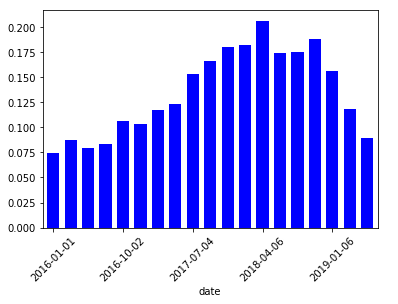

In [1221]:
visualise_hist_df(date_and_tag_df, 'go', norm='lin')

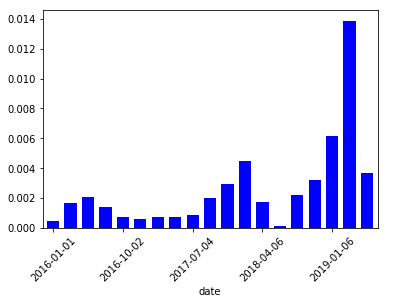

In [1222]:
visualise_hist_df(agile_date_tag_df, 'go', norm='lin')

# Comparing courses and job ads for each tag

## Loading Stack Overflow tag first usage dates

In [655]:
tag_earliest_uses_stackoverflow = pd.read_csv('/dlabdata1/yazdania/so_tag_data/tag_10_earliest_appearance.csv')

In [656]:
tag_first_use_so_df = tag_earliest_uses_stackoverflow[['CreationDate', 'Tag']].groupby('Tag').min().reset_index()
tag_nth_use_so_df = tag_earliest_uses_stackoverflow[['CreationDate', 'Tag']].groupby('Tag').nth(5).reset_index()

In [657]:
tag_first_use_so_df = tag_first_use_so_df.rename(columns={'CreationDate': 'TagFirstUseDate'})
tag_first_use_so_df['TagFirstUseDate'] = pd.to_datetime(tag_first_use_so_df['TagFirstUseDate'])

In [658]:
tag_nth_use_so_df = tag_nth_use_so_df.rename(columns={'CreationDate': 'TagNthUseDate'})
tag_nth_use_so_df['TagNthUseDate'] = pd.to_datetime(tag_nth_use_so_df['TagNthUseDate'])

In [659]:
tag_first_use_so_df.head()

Tag         TagFirstUseDate
0             .a 2010-01-28 20:14:23.093
1           .app 2009-11-10 20:17:10.437
2      .aspxauth 2010-01-23 10:33:10.970
3  .bash-profile 2009-05-26 01:13:33.993
4    .class-file 2009-11-20 04:01:01.393

## Loading course data

In [692]:
tag_df_dict_filename = '/dlabdata1/yazdania/trends_udemy/dataframes/course_first_mentions/tag_to_course_firsts_dict.pkl'
tag_to_df_dict = pickle.load(open(tag_df_dict_filename, 'rb'))
tags_with_first_appearances = pd.concat([tag_to_df_dict[current_tag].sort_values(by='created_content').head(1).
                                 assign(tag_name=(current_tag)).reset_index()
                                 for current_tag in tag_to_df_dict if
                                 tag_to_df_dict[current_tag].shape[0] > 0]).reset_index().drop(columns='index')
#tags_with_first_appearances['date'] = tags_with_first_appearances.apply(lambda x: max([x['created_content'], 
#                                                                                      x['published_time']]), axis=1)
tags_with_first_appearances['date'] = tags_with_first_appearances['created_content']

In [693]:
tags_with_nth_appearances = pd.concat([tag_to_df_dict[current_tag].sort_values(by='created_content').head(5).tail(1).
                                 assign(tag_name=(current_tag)).reset_index()
                                 for current_tag in tag_to_df_dict if
                                 tag_to_df_dict[current_tag].shape[0] > 0]).reset_index().drop(columns='index')
#tags_with_first_appearances['date'] = tags_with_first_appearances.apply(lambda x: max([x['created_content'], 
#                                                                                      x['published_time']]), axis=1)
tags_with_nth_appearances['date'] = tags_with_nth_appearances['created_content']

In [694]:
tags_with_first_appearances.loc[tags_with_first_appearances['date'] > datetime(2016,10,1)].shape

(2181, 7)

In [695]:
tag_to_df_dict['delphi']

created_content  \
course_id                       
24422     2012-09-08 12:57:57   
1175042   2017-04-10 02:59:36   
1231668   2017-05-27 10:14:00   
1320668   2017-08-13 21:31:23   
1320676   2017-08-13 21:44:12   
1378668   2017-10-04 08:31:28   
1382772   2017-10-06 10:10:59   
1846878   2018-08-09 09:42:31   
1861440   2018-08-17 06:03:48   

                                                       title  \
course_id                                                      
24422      Learn To Program with Pascal Master programmin...   
1175042                     Becoming a Delphi Language Ninja   
1231668    Delphi Solutions - Part 2 Over 30 examples to ...   
1320668    XML in Delphi Part 1 Create, read, and process...   
1320676    Building Data-Aware Applications in Delphi usi...   
1378668                                  Delphi Installation   
1382772                                  Delphi Installation   
1846878                     Back-End Development with Delphi   
1861440                                     Coding in Delphi   

                                                title_course  \
course_id                                                      
24422                           Learn To Program with Pascal   
1175042                            Delphi Solutions - Part 1   
1231668                            Delphi Solutions - Part 2   
1320668                                 XML in Delphi Part 1   
1320676    Building Data-Aware Applications in Delphi usi...   
1378668    Learning Path: Delphi: Cross-Platform Apps wit...   
1382772                                  Working with Delphi   
1846878                                     Mastering Delphi   
1861440              The Complete Delphi Masterclass: 3-in-1   

               published_time  
course_id                      
24422     2012-10-29 10:01:23  
1175042   2017-05-04 17:15:18  
1231668   2017-07-04 16:31:55  
1320668   2017-08-15 16:59:17  
1320676   2017-08-18 18:00:25  
1378668   2017-10-13 18:02:48  
1382772   2017-11-21 22:05:03  
1846878   2018-08-14 21:54:03  
1861440   2018-08-21 14:49:19

In [696]:
tags_with_first_appearances = pd.merge(tags_with_first_appearances, 
                                   tags_with_counts.
                                   rename(columns={'CreationDate': 'TagWikiDate'}), left_on='tag_name',
                                   right_on='TagName').sort_values('TagCount', ascending=False)

In [697]:
tags_with_first_appearances.head()

course_id     created_content  \
2787       8324 2011-06-28 08:26:18   
6551       9463 2011-09-03 02:16:27   
1734      11152 2011-11-17 04:38:28   
2008       9711 2011-09-16 03:23:49   
1840      12318 2012-01-03 01:30:08   

                                                  title  \
2787                  Adding Hello World JS to our HTML   
6551            Additional Java Control Flow Constructs   
1734              Additional C# Control Flow Constructs   
2008  Beginner PHP and MySQL Tutorial Learn PHP and ...   
1840         Alice_File -  Python File ( For Module 16)   

                                           title_course      published_time  \
2787                           Javascript for Beginners 2011-07-09 05:43:31   
6551  Programming Java for Beginners - The Ultimate ... 2011-09-15 15:19:57   
1734     Learning C# .NET - Programming for Beginners.  2011-11-29 01:29:27   
2008                    Beginner PHP and MySQL Tutorial 2011-09-19 21:09:35   
1840                Learn Python, it's CAKE (Beginners) 2012-01-15 21:24:00   

        tag_name                date  Id  TagCount     TagName  \
2787  javascript 2011-06-28 08:26:18   3   1856235  javascript   
6551        java 2011-09-03 02:16:27  17   1577864        java   
1734          c# 2011-11-17 04:38:28   9   1336521          c#   
2008         php 2011-09-16 03:23:49   5   1301091         php   
1840      python 2012-01-03 01:30:08  16   1228872      python   

                                                Excerpt         TagWikiDate  
2787  JavaScript (not to be confused with Java) is a... 2010-09-02 08:18:03  
6551  Java (not to be confused with JavaScript, JScr... 2010-09-02 08:18:03  
1734  C# (pronounced "see sharp") is a high level, s... 2010-09-02 08:18:03  
2008  PHP (PHP: Hypertext Preprocessor) is a widely ... 2010-09-02 08:15:42  
1840  Python is a multi-paradigm, dynamically typed,... 2010-09-02 08:18:03

## Preparing ad data

In [698]:
tag_first_mentions_ads = date_and_tag_df.groupby('tag').min().reset_index()

In [699]:
tag_nth_mentions_ads = date_and_tag_df.groupby('tag').nth(5).reset_index()

In [700]:
len(set(tag_first_mentions_ads.tag.values))

19340

In [701]:
tag_first_mentions_ads.loc[tag_first_mentions_ads.published > datetime(2016,10,1)].shape

(8445, 3)

In [702]:
tag_first_mentions_ads.head(10)

tag                                  author           published
0      ..net                                 Snowden 2017-11-28 03:06:45
1         .a                                Cinchapi 2019-06-20 13:05:39
2       .c++                                   Intel 2016-06-19 06:42:57
3       .doc                             Ballotpedia 2017-02-03 11:45:02
4       .dot              LEAP Software Developments 2016-02-17 03:08:52
5      .dotm              LEAP Software Developments 2016-02-17 03:08:52
6  .htaccess                                 Kognito 2016-02-24 05:04:32
7       .net                                         2015-12-07 19:10:50
8   .net-1.1              AMSYS Innovative Solutions 2019-05-05 02:35:23
9   .net-2.0  Blue Cross and Blue Shield of Nebraska 2016-01-15 19:50:39

## Loading word2vec data

In [703]:
word2vec_mat = pickle.load(open('/dlabdata1/yazdania/so_word2vec/vectors_matrix.pkl', 'rb'))
words_dict = json.load(open('/dlabdata1/yazdania/so_word2vec/words_map.json', 'r'))

In [704]:
word2vec_mat.shape

(1224795, 200)

In [705]:
from utilities.text_utils import tokenise_stem_punkt_and_stopword
from utilities.constants import PUNKT

In [706]:
def calculate_word2vec_vector(text):
    if text == np.NaN or text is None:
        return np.zeros((word2vec_mat.shape[1]))
    tokenised_text = tokenise_stem_punkt_and_stopword(text, punkt_to_remove=''.join([x for x in PUNKT if x != '.']))
    row_indices = [words_dict.get(x, None) for x in tokenised_text]
    row_indices = [x for x in row_indices if x is not None]
    n_words = len(row_indices)
    if n_words == 0:
        return np.zeros((word2vec_mat.shape[1]))
    vector_to_return = np.sum(word2vec_mat[row_indices, :], axis=0)
    vector_to_return = vector_to_return / n_words
    return vector_to_return

In [707]:
calculate_word2vec_vector('node.js is really nice but I like react better')

array([-1.67212689e-01,  5.33334597e-02, -4.81284788e-02,  1.28755825e-01,
        1.07517650e-01,  1.60917696e-02, -1.08884115e-01,  1.61244651e-01,
       -9.22465398e-03, -1.00725050e-01, -1.24382238e-01,  4.57766978e-02,
        3.18376940e-02, -5.01937702e-02, -9.97680236e-02, -1.36347693e-01,
        5.95680081e-03, -1.26921194e-01,  3.38028148e-02,  7.31620633e-02,
        1.17880624e-01,  4.31578880e-02,  8.52373849e-02,  1.52077518e-01,
        7.26879776e-02,  8.93297947e-03,  3.70575730e-02, -1.95994578e-01,
       -8.86266732e-02,  1.28064259e-01, -5.94760650e-02,  4.04264592e-03,
        7.46968345e-02,  1.27666217e-01,  1.54673443e-01, -1.03515320e-01,
        1.18495989e-01, -8.28689089e-02, -9.54325649e-02, -2.74391949e-02,
       -5.15531196e-02, -3.76041892e-02,  5.46654370e-02,  1.98741490e-02,
       -1.62475618e-01, -2.65767947e-02, -9.33182472e-02,  6.27802558e-02,
       -5.52668947e-02,  6.22427731e-02, -2.64844326e-02, -2.63531183e-02,
       -6.30307465e-02, -

## Both platforms considered only after _their own_ warm-up periods

Unfair to ads. Ads achieved their warmup much later, and we'd eliminate tags that had a course quite late and an ad very early.

## Courses considered after courses' warmup

Unfair to ads. It's clear why.

## Courses considered after SO Jobs' launch

Unfair to courses. Allows the inclusion of tags that had a course too late, but the tags that had a course before SO Jobs and had actually gotten their course quickly would be eliminated.

## Both considered after ads' warm-up period

This is probably the one that makes the most sense. Of course, we're removing both tags that had a course too late and tags that had an ad too late, but at least we're cutting down on both sides and not just on one.

In [735]:
tags_with_first_appearances.loc[tags_with_first_appearances.tag_name == 'ionic2']

course_id     created_content                        title  \
1501     755932 2016-02-08 12:25:42  Advanced Ionic 2 Components   

             title_course      published_time tag_name                date  \
1501  Introducing Ionic 2 2016-02-08 20:43:47   ionic2 2016-02-08 12:25:42   

          Id  TagCount TagName  \
1501  115914     12164  ionic2   

                                                Excerpt         TagWikiDate  
1501  Ionic 2 is the next generation of Ionic, the o... 2015-12-17 15:00:46

In [709]:
merged_both_after_warmup = pd.merge(tag_first_mentions_ads.loc[tag_first_mentions_ads['published'] >= datetime(2016,10,1)], 
                  tags_with_first_appearances.loc[
                  tags_with_first_appearances['date'] >= datetime(2016,10,1)], left_on='tag', right_on='TagName')\
                            [['tag', 'author', 'published', 'date', 'TagCount', 'Excerpt', 'TagWikiDate']].rename(
                            columns={'published': 'ad_date', 'date': 'course_date'}).\
                            sort_values('TagCount', ascending=False)
merged_both_after_warmup = pd.merge(merged_both_after_warmup, tag_first_use_so_df, 
                                    left_on='tag', right_on='Tag').drop(columns=['Tag'])
merged_both_after_warmup = pd.merge(merged_both_after_warmup, tag_nth_use_so_df[['Tag', 'TagNthUseDate']], how='left',
                                    left_on='tag', right_on='Tag').drop(columns=['Tag'])
merged_both_after_warmup = pd.merge(merged_both_after_warmup, tag_nth_mentions_ads[['tag', 'published']], how='left',
                                    left_on='tag', right_on='tag').rename(columns={'published': 'nth_ad_date'})
merged_both_after_warmup = pd.merge(merged_both_after_warmup, 
                                    tags_with_nth_appearances[['tag_name', 'date']], how='left', 
                                    left_on='tag', right_on='tag_name').drop(columns=['tag_name']).\
                                    rename(columns={'date': 'nth_course_date'})
merged_both_after_warmup['difference_in_days'] = merged_both_after_warmup.apply(lambda x: (x['course_date'] - x['ad_date']).days, axis=1)
merged_both_after_warmup['difference_from_tag_first_use'] = merged_both_after_warmup.apply(lambda x: 
                          (min([x['course_date'], x['ad_date']]) - x['TagFirstUseDate']).days, axis=1)
merged_both_after_warmup['difference_from_tag_wiki'] = merged_both_after_warmup.apply(lambda x: 
                          (min([x['course_date'], x['ad_date']]) - x['TagWikiDate']).days, axis=1)
merged_both_after_warmup.describe()

TagCount  difference_in_days  difference_from_tag_first_use  \
count    632.000000          632.000000                     632.000000   
mean     848.028481          -97.295886                    1602.889241   
std     1549.331449          327.802460                    1209.270851   
min        1.000000         -985.000000                    -778.000000   
25%       83.000000         -299.750000                     495.750000   
50%      295.000000          -97.000000                    1456.000000   
75%      906.500000          139.250000                    2871.500000   
max    15043.000000          793.000000                    3817.000000   

       difference_from_tag_wiki  
count                632.000000  
mean                 904.704114  
std                  875.791539  
min                 -995.000000  
25%                  149.500000  
50%                  804.500000  
75%                 1694.000000  
max                 2775.000000

In [710]:
merged_both_after_warmup = merged_both_after_warmup.rename(columns={'tag':'TagName'})

In [711]:
tags_created_after_warmup = merged_both_after_warmup.loc[
            merged_both_after_warmup.TagFirstUseDate >= datetime(2016,10,1)].TagName.values

len(tags_created_after_warmup)

113

Let's see what percentage of the tags are ad before course, both among those all, and among those that had the tag created less than three years before than the first ad/course (includes tags created after first tag/course).

In [799]:
limited_by_creation_date = merged_both_after_warmup.loc[
    merged_both_after_warmup.TagFirstUseDate >= datetime(2015,10,1)]

In [800]:
print(limited_by_creation_date.shape[0], 
 limited_by_creation_date.loc[limited_by_creation_date.difference_in_days > 0].shape[0], \
            limited_by_creation_date.loc[limited_by_creation_date.difference_in_days > 0].shape[0]/
             limited_by_creation_date.shape[0])


print(merged_both_after_warmup.shape[0], 
 merged_both_after_warmup.loc[merged_both_after_warmup.difference_in_days > 0].shape[0], \
            merged_both_after_warmup.loc[merged_both_after_warmup.difference_in_days > 0].shape[0]/
             merged_both_after_warmup.shape[0])

195 69 0.35384615384615387
632 239 0.37816455696202533


Also let's see the number of tags that were created less than 3 years before the first ad/course, but also not after them. Then let's compare it with the proportion of tag before ad/course tags in the full set.

In [714]:
print(limited_by_creation_date.loc[limited_by_creation_date.difference_from_tag_wiki > 0].shape[0] / \
                    limited_by_creation_date.shape[0])

print(merged_both_after_warmup.loc[merged_both_after_warmup.difference_from_tag_wiki > 0].shape[0] / \
                    merged_both_after_warmup.shape[0])

print(limited_by_creation_date.loc[limited_by_creation_date.difference_from_tag_first_use > 0].shape[0] / \
                    limited_by_creation_date.shape[0])

print(merged_both_after_warmup.loc[merged_both_after_warmup.difference_from_tag_first_use > 0].shape[0] / \
                    merged_both_after_warmup.shape[0])

0.7240437158469946
0.8401898734177216
0.8797814207650273
0.930379746835443


So the proportion decreases, but it's still above 70%.

In [715]:
merged_both_after_warmup['ExcerptVec'] = merged_both_after_warmup.Excerpt.apply(calculate_word2vec_vector)

In [716]:
merged_both_after_warmup['AdFirst'] = merged_both_after_warmup.difference_in_days.apply(lambda x: x > 0)

In [717]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merged_both_after_warmup.loc[merged_both_after_warmup.difference_in_days>0])

TagName  \
0                        vuejs2   
6                      pthreads   
10       google-cloud-datastore   
15                    retrofit2   
17              azure-functions   
18                   automapper   
20                          hql   
27                        c++17   
28           hyperledger-fabric   
30             static-libraries   
32                      pytorch   
38              aws-api-gateway   
41                        boto3   
45          asp.net-core-webapi   
47                     symfony4   
48         azure-service-fabric   
49                     postback   
52              azure-pipelines   
53                    tidyverse   
55                         ngrx   
57            angular2-services   
59                     keycloak   
61                   setuptools   
64            compiler-warnings   
69                      gremlin   
70              barcode-scanner   
72                         dask   
74                 resttemplate   
76                     paramiko   
78   azure-application-insights   
84                   amazon-sns   
87                       guzzle   
88                          elf   
89                       gatsby   
93                     word2vec   
94                         poco   
96           image-segmentation   
100                    node-red   
101                         ini   
103          firebase-analytics   
105                     next.js   
106                  redux-saga   
107                       spacy   
108             code-formatting   
109                     xgboost   
110                      jacoco   
111                 large-files   
112                       gnupg   
113                owl-carousel   
114                react-apollo   
116            azure-powershell   
125               cache-control   
126          server-sent-events   
128             azure-data-lake   
131                        cpan   
133                         ode   
135                     lattice   
141               azure-iot-hub   
144                     traefik   
146                scikit-image   
147                      arcore   
155                  diacritics   
160               gradle-plugin   
167     informatica-powercenter   
168                     cpython   
169        azure-api-management   
173                     tfs2017   
179                    ramda.js   
180                 autosuggest   
183             android-jetpack   
188                       istio   
189                    opensuse   
190                arm-template   
192        serial-communication   
196                    iphone-x   
198                     aws-iot   
199                  ngrx-store   
208              postgresql-9.6   
210                dynamics-365   
211                     php-7.2   
217               cucumber-java   
219                data-fitting   
220                     firedac   
223                      specs2   
225                       mxnet   
227                        aidl   
229                   node-sass   
236                        cntk   
237                     netlify   
245                       bulma   
247     functional-dependencies   
250            azure-automation   
251                     netstat   
257                  apostrophe   
272                    undertow   
273             memory-barriers   
275                      c#-7.0   
276                         joi   
278                    watchdog   
279                 fixed-point   
280                      pundit   
287             web-api-testing   
291                  superagent   
292                     save-as   
295                        php4   
297                laravel-dusk   
298            azure-kubernetes   
299              azure-api-apps   
303                         rpa   
311                        mern   
312                        rssi   
313                       inode   
317                         aot   
322                     sightly   

In [718]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merged_both_after_warmup.loc[merged_both_after_warmup.difference_in_days<0])

TagName  \
1            google-cloud-firestore   
2                          json.net   
3                            ionic3   
4                     mongodb-query   
5          firebase-cloud-messaging   
7                       java-stream   
8            google-cloud-functions   
9                             axios   
11                         angular5   
12                 linq-to-entities   
13                            pyqt5   
14                         wxpython   
16                    vue-component   
19                          maven-3   
21                           racket   
22                         javamail   
23                       python-3.6   
24                      laravel-5.3   
25                      laravel-5.4   
26                          pymongo   
29                              wmi   
31                        typeerror   
33                 react-navigation   
34                   azure-cosmosdb   
35                  unity-container   
36                    raspberry-pi3   
37                            antlr   
39                             lstm   
40                             vuex   
42                   amazon-cognito   
43                           ionic4   
44                httpurlconnection   
46                angular-material2   
50                      laravel-5.5   
51                   angular2-forms   
54                       vuetify.js   
56                             nsis   
58                             xlsx   
60                            arkit   
62                           roslyn   
63                          nuxt.js   
65                           gcloud   
66                           okhttp   
67                      soap-client   
68                           emgucv   
71                      iis-express   
73               typescript-typings   
75                      laravel-5.6   
77                       python-3.7   
79                            tidyr   
80                   caliburn.micro   
81                        indexeddb   
82                      react-hooks   
83                        powermock   
85                  bean-validation   
86                   spring-webflux   
90                             sha1   
91                      statsmodels   
92                        slack-api   
95                              lex   
97                scala-collections   
98                        webpack-2   
99                   static-linking   
102                            glfw   
104                     tensorboard   
115                       shapefile   
117                         knex.js   
118                     chef-recipe   
119                          netcdf   
120                         kubectl   
121                 apache-zeppelin   
122                     private-key   
123                android-livedata   
124                           p5.js   
127                       lubridate   
129                        rubymine   
130             key-value-observing   
132                        androidx   
134                           gnome   
136                     razor-pages   
137                 android-camera2   
138                    unit-of-work   
139                         keytool   
140                       webpack-4   
142                            hmac   
143                   apollo-client   
145                        autofill   
148                           epoch   
149                          junit5   
150                   amazon-athena   
151                      httpserver   
152              visual-studio-2019   
153                           rbenv   
154                             rdp   
156                        jsonpath   
157                gradient-descent   
158                    force-layout   
159                          mcrypt   
161                        minikube   
162                         java-11   
163                            glew   
164                    ionic-native   
165        

In [719]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(merged_both_after_warmup[['TagName', 'Excerpt']])

TagName  \
0    vuejs2                           
1    google-cloud-firestore           
2    json.net                         
3    ionic3                           
4    mongodb-query                    
5    firebase-cloud-messaging         
6    pthreads                         
7    java-stream                      
8    google-cloud-functions           
9    axios                            
10   google-cloud-datastore           
11   angular5                         
12   linq-to-entities                 
13   pyqt5                            
14   wxpython                         
15   retrofit2                        
16   vue-component                    
17   azure-functions                  
18   automapper                       
19   maven-3                          
20   hql                              
21   racket                           
22   javamail                         
23   python-3.6                       
24   laravel-5.3                      
25   laravel-5.4                      
26   pymongo                          
27   c++17                            
28   hyperledger-fabric               
29   wmi                              
30   static-libraries                 
31   typeerror                        
32   pytorch                          
33   react-navigation                 
34   azure-cosmosdb                   
35   unity-container                  
36   raspberry-pi3                    
37   antlr                            
38   aws-api-gateway                  
39   lstm                             
40   vuex                             
41   boto3                            
42   amazon-cognito                   
43   ionic4                           
44   httpurlconnection                
45   asp.net-core-webapi              
46   angular-material2                
47   symfony4                         
48   azure-service-fabric             
49   postback                         
50   laravel-5.5                      
51   angular2-forms                   
52   azure-pipelines                  
53   tidyverse                        
54   vuetify.js                       
55   ngrx                             
56   nsis                             
57   angular2-services                
58   xlsx                             
59   keycloak                         
60   arkit                            
61   setuptools                       
62   roslyn                           
63   nuxt.js                          
64   compiler-warnings                
65   gcloud                           
66   okhttp                           
67   soap-client                      
68   emgucv                           
69   gremlin                          
70   barcode-scanner                  
71   iis-express                      
72   dask                             
73   typescript-typings               
74   resttemplate                     
75   laravel-5.6                      
76   paramiko                         
77   python-3.7                       
78   azure-application-insights       
79   tidyr                            
80   caliburn.micro                   
81   indexeddb                        
82   react-hooks                      
83   powermock                        
84   amazon-sns                       
85   bean-validation                  
86   spring-webflux                   
87   guzzle                           
88   elf                              
89   gatsby                           
90   sha1                             
91   statsmodels                      
92   slack-api                        
93   word2vec                         
94   poco                             
95   lex                              
96   image-segmentation               
97   scala-collections                
98   webpack-2                        
99   static-linking                   
100  node-red                         
101  ini                              
102  glfw  

In [720]:
with open('matched_tags_dataframe.pkl','wb') as f:
    pickle.dump(merged_both_after_warmup, f)

Saving the tags to then get their Google Trends.

In [721]:
with open('/dlabdata1/yazdania/google_trends/trends_set_4/tags_to_get.txt', 'w') as f:
    f.write('\n'.join(merged_both_after_warmup.TagName.
                      apply(lambda x: '"' + (' '.join(x.split('-')) if '-' in x else x) + '"').values))

In [833]:
merged_both_after_warmup[['TagName']].to_csv('../tags_to_categorise.csv')

In [722]:
matched_tag_types = pd.read_csv('/home/yazdania/so_jobs_analysis/matched_tag_types.csv')

In [723]:
matched_tag_types.groupby('type').count()

tag
type             
api            17
company         1
concept       145
coresubset     89
db              7
deprecated      7
device          3
doc             1
feature        59
features        1
format         11
framework      33
ide             2
language       13
legacydevice    1
library        67
middleware      5
platform       13
plugin          1
protocol        7
sdk             4
service        13
software       98
standard        1
technique       1
toolkit         1
version        32
what            1
wrapper         2

## Visualising some of the tags to see their Google Trends and Stack Overflow behaviour

In [724]:
from functools import reduce
def load_google_trends_file(filename, names_have_quotations=False):
    trend_df_dict = pickle.load(open(filename, 'rb'))
    trends = reduce(lambda x, y: pd.merge(x, y, left_index=True, right_index=True), list(trend_df_dict.values()))
    trends.index = pd.to_datetime(trends.index, dayfirst=True)
    col_name_list = trends.columns.values
    for col_name in col_name_list:
        current_col_name = col_name
        if ' ' in current_col_name:
            old_col_name = current_col_name
            current_col_name = current_col_name.replace(' ', '-')
            trends[current_col_name] = trends[old_col_name]
            trends = trends.drop(old_col_name, axis=1)
            
        if names_have_quotations:
            old_col_name = current_col_name
            current_col_name = current_col_name.replace('"', '')
            trends[current_col_name] = trends[old_col_name]
            trends = trends.drop(old_col_name, axis=1)
            
        if current_col_name == 'date':
            continue
        if trends[current_col_name].dtype == 'int' or trends[current_col_name].dtype == 'float':
            continue
        trends[current_col_name] = trends[current_col_name].apply(lambda x: int(x) if '<' not in x else 0)
    return trends

def filter_df_by_date(df, min_date, max_date, date_field):
    return df.loc[(df[date_field] >= min_date) & (df[date_field] <= max_date)]

def add_value_at_beginning(df, min_date, tag):
    min_value = df['cumulative_value'].min()-1
    if min_value >= 0:
        df = df.append({'date': min_date, 'tag': tag, 'cumulative_value': min_value}, ignore_index=True).\
                                sort_values(by='cumulative_value')
    return df

def plot_trends_and_tags(trends_df, tag_ad_and_course_df,
                        y1_label = 'Google Trends', date_col_name='date'):
    tags_to_get = [x for x in trends_df.columns.values if x != date_col_name]
    earliest_date = trends_df[date_col_name].min()
    latest_date = trends_df[date_col_name].max()
    tag_first_dates = tag_ad_and_course_df.loc[tag_ad_and_course_df.TagName.apply(lambda x: x in tags_to_get)]
    #current_index = 0
    fig = plt.figure(figsize=(20,int(np.ceil((len(trends_df.columns)-1)/5))*5))
    for current_index in range(len(tags_to_get)):
        ax1 = fig.add_subplot(int(np.ceil((len(trends_df.columns)-1)/5)),5,current_index+1)
#         if current_index >= len(colour_map):
#             break
        #print(trends_df['date'])
        ax1.plot(trends_df[date_col_name], trends_df[tags_to_get[current_index]], 
                 color='blue', 
                label=tags_to_get[current_index])
        current_tag_row = tag_first_dates.loc[tag_first_dates.TagName == tags_to_get[current_index]]
        if 'ad_date' in tag_ad_and_course_df.columns.values:
            # The date of the first advert is marked by a black dotted line
            if not pd.isnull(current_tag_row['ad_date'].values[0]):
                ax1.axvline(x=current_tag_row['ad_date'].values[0], linestyle=':', 
                                            color='black')
        if 'nth_ad_date' in tag_ad_and_course_df.columns.values:
            # The date of the nth advert is marked by a black dashed and dotted line
            if not pd.isnull(current_tag_row['nth_ad_date'].values[0]):
                ax1.axvline(x=current_tag_row['nth_ad_date'].values[0], linestyle='-.', 
                                            color='black')
        if 'course_date' in tag_ad_and_course_df.columns.values:
            # The date of the first course is marked by a green dotted line.
            if not pd.isnull(current_tag_row['course_date'].values[0]):
                ax1.axvline(x=current_tag_row['course_date'].values[0], linestyle=':', 
                                                color='green')
        if 'nth_course_date' in tag_ad_and_course_df.columns.values:
            # The date of the first course is marked by a green dotted line.
            if not pd.isnull(current_tag_row['nth_course_date'].values[0]):
                ax1.axvline(x=current_tag_row['nth_course_date'].values[0], linestyle='-.', 
                                                color='green')
        if 'TagFirstUseDate' in tag_ad_and_course_df.columns.values:
            # The first use date of the tag is marked by a red dotted line.
            if not pd.isnull(current_tag_row['TagFirstUseDate'].values[0]):
                ax1.axvline(x=current_tag_row['TagFirstUseDate'].values[0], linestyle=':', 
                                        color='red')
        if 'TagNthUseDate' in tag_ad_and_course_df.columns.values:
            # The first use date of the tag is marked by a red dashed and dotted line.
            if not pd.isnull(current_tag_row['TagNthUseDate'].values[0]):
                ax1.axvline(x=current_tag_row['TagNthUseDate'].values[0], linestyle='-.', 
                                        color='red')

        if current_index % 5 == 0:
            ax1.set_ylabel(y1_label+' volume', fontsize=10)
    #ax1.set_yticks(np.arange(0, 101, 10))
        #ax1.set_xlabel('Time', fontsize=10)
        ax1.tick_params(axis='both', which='major', labelsize=10)
        ax1.tick_params(axis='x', rotation=45)
        ax1.set_title(tags_to_get[current_index])
    #plt.legend(fontsize=20)
    plt.show()

In [725]:
def load_stackoverflow_trends_with_google_trends(google_trends_df, so_tag_index, so_weeks, so_timeseries,
                                                normalise = False, date_col_name='date'):
    so_timeseries = np.array(so_timeseries.todense())
    tags_to_get = [(x, so_tag_index[x]) for x in google_trends_df.columns if x != date_col_name]
    earliest_date = google_trends_df[date_col_name].min()
    latest_date = google_trends_df[date_col_name].max()
    # Since the 0-th column of the so_timeseries matrix is before the first element of so_weeks, 
    # we need to add 1 to each of the indices to find the column indices for that matrix.
    start_index = bisect_left(so_weeks, earliest_date) + 1 + 1
    end_index = bisect(so_weeks, latest_date) - 1 + 1
    
    result_df = google_trends_df.copy()
    max_value = 0
    for tag_info in tags_to_get:
        current_col = np.array(so_timeseries[tag_info[1], start_index:end_index]).flatten()
        if np.max(current_col) > max_value:
            max_value = np.max(current_col)
        result_df['so_'+tag_info[0]] = pd.Series(current_col)
    
    if normalise:
        for tag_info in tags_to_get:
            result_df['so_'+tag_info[0]] = result_df['so_'+tag_info[0]]*100.0 / max_value
    return result_df, max_value

def load_stack_overflow_trends(tags_to_get, so_tag_index, so_weeks, so_timeseries,
                                                normalise = False, step_size=1):
    so_timeseries = np.array(so_timeseries.todense())
    tags_to_get = [(x, so_tag_index[x]) for x in tags_to_get]
    earliest_date = so_weeks[1]
    latest_date = so_weeks[-1]
    result_dict = dict()
    index_list = pd.to_datetime(pd.Series([so_weeks[i] for i in range(step_size, len(so_weeks)) 
                                           if i % step_size == 0]))
    result_dict['date'] = index_list
    
    max_value = 0
    for tag_info in tags_to_get:
        current_col = np.array(so_timeseries[tag_info[1], 2:]).flatten()
        if step_size > 1:
            current_col = np.array([sum(current_col[i:i+step_size]) for i in range(len(so_weeks)) 
                                    if i % step_size == 0])
        if np.max(current_col) > max_value:
            max_value = np.max(current_col)
        result_dict[tag_info[0]] = pd.Series(current_col)
        
    return pd.DataFrame.from_dict(result_dict, orient='columns').set_index('date')

def drop_google_trends_cols(combined_trends_df, date_col_name='date'):
    columns_to_drop = [x for x in combined_trends_df.columns if x != date_col_name and 'so_' not in x]
    result_df = combined_trends_df.copy().drop(columns_to_drop, axis=1)
    result_df = result_df.rename(columns={x: x.split('_')[1] for x in result_df.columns if x != date_col_name})
    return result_df

In [726]:
group1_trends = load_google_trends_file('/dlabdata1/yazdania/google_trends/trends_set_4/final_df_dict.pkl', 
                                        names_have_quotations=True)

In [727]:
group1_trends.head()

ionic2  google-cloud-firestore  json.net  mongodb-query  \
date                                                                  
2014-01-05     0.0                     0.0     20.21        17.1879   
2014-01-12     0.0                     0.0     23.03        22.7010   
2014-01-19     0.0                     0.0     37.13        15.5664   
2014-01-26     0.0                     0.0     30.08        13.6206   
2014-02-02     0.0                     0.0     29.14        14.5935   

            firebase-cloud-messaging  pthreads  java-stream  \
date                                                          
2014-01-05                       0.0    9.7478     6.546081   
2014-01-12                       0.0    7.7409     6.546081   
2014-01-19                       0.0   12.9015     6.546081   
2014-01-26                       0.0   13.7616     6.546081   
2014-02-02                       0.0   12.3281     5.455067   

            google-cloud-functions  google-cloud-datastore  angular5  \
date                                                                   
2014-01-05                     0.0                2.013408       0.0   
2014-01-12                     0.0                2.013408       0.0   
2014-01-19                     0.0                2.013408       0.0   
2014-01-26                     0.0                0.000000       0.0   
2014-02-02                     0.0                2.085315       0.0   

            linq-to-entities     pyqt5  wxpython  swift4  vue-component  \
date                                                                      
2014-01-05           14.4384  0.000000     53.76     0.0            0.0   
2014-01-12           22.5600  4.411139     42.56     0.0            0.0   
2014-01-19           10.6032  4.411139     36.40     0.0            0.0   
2014-01-26           21.8832  4.411139     47.04     0.0            0.0   
2014-02-02           15.1152  4.411139     50.40     0.0            0.0   

            azure-functions  material-ui  automapper    maven-3   hql  
date                                                                   
2014-01-05              0.0          0.0     27.8250  10.638298  50.0  
2014-01-12              0.0          0.0     21.3325   8.510638  41.0  
2014-01-19              0.0          0.0     27.8250   8.510638  29.0  
2014-01-26              0.0          0.0     29.6800   4.255319  50.0  
2014-02-02              0.0          0.0     12.9850   8.510638  33.0

In [728]:
from scipy.sparse import coo_matrix

In [729]:
so_tag_index = json.load(open('/dlabdata1/yazdania/trends_udemy/tag_to_index.json', 'r'))
so_week_index = pickle.load(open('/dlabdata1/yazdania/trends_udemy/tag_time_series_longer/week_index.pkl','rb'))
so_timeseries = pickle.load(open('/dlabdata1/yazdania/trends_udemy/tag_time_series_longer/tag_timeseries_matrix.pkl','rb'))
# so_timeseries = coo_matrix((so_timeseries[2], (so_timeseries[0], so_timeseries[1])), shape=(len(so_tag_index), len(so_week_index)+1)).tocsr()


In [730]:
len(so_week_index)

600

In [731]:
group1_with_stackoverflow, group1_max = \
        load_stackoverflow_trends_with_google_trends(group1_trends.reset_index(), 
                                                 so_tag_index, so_week_index, so_timeseries,
                                                normalise = False, date_col_name='date')

In [732]:
# plot_trends_and_tags(group1_trends.reset_index(), 
#                      merged_both_after_warmup,
#                      y1_label = 'Google Trends', date_col_name='date')

In [733]:
group1_so_only=load_stack_overflow_trends(merged_both_after_warmup.head(150).TagName.values, 
                                               so_tag_index, so_week_index, so_timeseries,
                                                normalise = False)

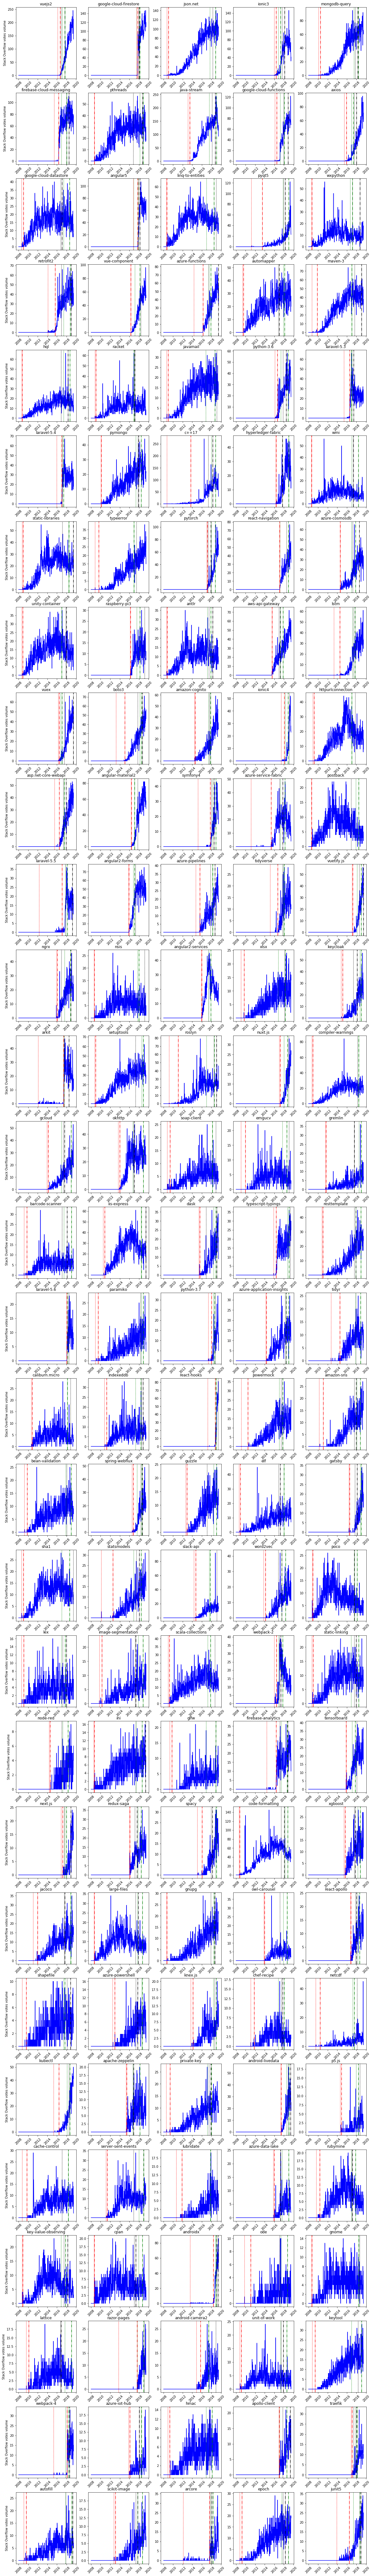

In [734]:
plot_trends_and_tags(group1_so_only.reset_index(), 
                     merged_both_after_warmup,
                     y1_label = 'Stack Overflow votes', date_col_name='date')

In [826]:
n_for_courses = 5
n_for_ads = 5
n_for_soq = 5

def sort_adoption_sequence(data_dict):
    data_dict = {k:np.datetime64(data_dict[k]) for k in data_dict if data_dict[k] is not pd.NaT}
    keys = list(data_dict.keys())
    values = np.array([data_dict[x] for x in keys])
    sorting_indices = np.argsort(values)
    keys_ordered = [keys[i] for i in sorting_indices]
    return '-'.join(keys_ordered)

def calculate_full_individual_adoption_sequence(tag_early_appearances, 
                                so_votes_date=pd.NaT, google_trends_date=pd.NaT):
    data_dict = {'SQ1': tag_early_appearances['TagFirstUseDate'],
                 'SQ'+str(n_for_soq): tag_early_appearances['TagNthUseDate'],
                 'A1': tag_early_appearances['ad_date'],
                 'C1': tag_early_appearances['course_date'],
                 'A'+str(n_for_ads): tag_early_appearances['nth_ad_date'],
                 'C'+str(n_for_courses): tag_early_appearances['nth_course_date'],
                 'SV': so_votes_date,
                 'GT': google_trends_date}
    return sort_adoption_sequence(data_dict)

def calculate_short_adoption_sequence(tag_early_appearances, 
                                so_votes_date=pd.NaT, google_trends_date=pd.NaT):
    data_dict = {'SQ': tag_early_appearances['TagFirstUseDate'],
                 'A': tag_early_appearances['ad_date'],
                 'C': tag_early_appearances['course_date'],
                 'SV': so_votes_date,
                 'GT': google_trends_date}
    return sort_adoption_sequence(data_dict)

#def to_days()

def populate_delays_dict(delays_dict, data_dict):
    data_dict = {k:np.datetime64(data_dict[k]) for k in data_dict if data_dict[k] is not pd.NaT}
    delays_dict = {k: (data_dict[k.split('_')[1]] - data_dict[k.split('_')[0]]).\
                               astype('timedelta64[D]') / np.timedelta64(1, 'D')
                   for k in delays_dict 
                   if k.split('_')[0] in data_dict and k.split('_')[1] in data_dict}
    return delays_dict

def calculate_inter_and_intra_platform_delays(tag_early_appearances, 
                                so_votes_date=pd.NaT, google_trends_date=pd.NaT):
    data_dict = {'SQ1': tag_early_appearances['TagFirstUseDate'],
                 'SQ'+str(n_for_soq): tag_early_appearances['TagNthUseDate'],
                 'A1': tag_early_appearances['ad_date'],
                 'C1': tag_early_appearances['course_date'],
                 'A'+str(n_for_ads): tag_early_appearances['nth_ad_date'],
                 'C'+str(n_for_courses): tag_early_appearances['nth_course_date'],
                 'SV': so_votes_date,
                 'GT': google_trends_date}
    
    return_dict = {'SQ1_SQ5': None,
                   'SQ1_SV': None,
                   'SQ1_A1': None,
                   'SQ1_SV': None,
                   'A1_A5': None,
                   'SQ1_C1': None,
                   'C1_C5': None,
                   'SV_A1': None,
                   'GT_A1': None,
                   'SV_C1': None,
                   'GT_C1': None,
                   'A1_C1': None}
    
    return populate_delays_dict(return_dict, data_dict)

def calculate_stackoverflow_votes_date(tag, stackoverflow_votes_df, threshold_rel=0.1, threshold_abs=5):
    # calculates the first time when the time series reached 10% of its median
    sub_df = stackoverflow_votes_df.loc[stackoverflow_votes_df[tag] > 0, tag]
    if sub_df.shape[0] == 0:
        return pd.NaT
    first_nonzero = sub_df.head(1).index.values[0]
    median_value = stackoverflow_votes_df.loc[stackoverflow_votes_df.index >= first_nonzero, tag].median()
    above_threshold = stackoverflow_votes_df.loc[
                        stackoverflow_votes_df[tag] >= max([median_value*threshold_rel, threshold_abs]), 
                                                            tag]
    if above_threshold.shape[0] == 0:
        return pd.NaT
    first_date_above_threshold = above_threshold.head(1).index.values[0]
    return first_date_above_threshold

def calculate_all_adoption_sequences(all_tags_early_appearances, stackoverflow_votes_df=None, google_trends_df=None):
    full_adoption_sequences = all_tags_early_appearances.apply(lambda x: 
             calculate_full_individual_adoption_sequence(x, 
                         so_votes_date=calculate_stackoverflow_votes_date(x['TagName'], stackoverflow_votes_df)), 
                                                               axis=1)
    
    short_adoption_sequences = all_tags_early_appearances.apply(lambda x: 
                             calculate_short_adoption_sequence(x, 
                    so_votes_date=calculate_stackoverflow_votes_date(x['TagName'], stackoverflow_votes_df)), axis=1)
    
    adoption_delays = all_tags_early_appearances.apply(lambda x: 
             calculate_inter_and_intra_platform_delays(x, 
                         so_votes_date=calculate_stackoverflow_votes_date(x['TagName'], stackoverflow_votes_df)), 
                                                               axis=1).apply(pd.Series)
    
    adoption_df = pd.concat([all_tags_early_appearances['TagName'], full_adoption_sequences, 
                             short_adoption_sequences, adoption_delays], axis=1).\
                             rename(columns={0:'full_adoption_seq', 1:'short_adoption_seq'})
    return adoption_df

def get_proportion_of_starting_element(df, seq_col, starting_elem):
    return df.loc[df[seq_col].apply(lambda x: x[0] == starting_elem)].TagName.sum() / df.TagName.sum()

def calculate_ordering_proportion(df, seq_col, first_elem, second_elem):
    return (df.loc[df[seq_col].apply(lambda x: x.index(first_elem) != -1 and x.index(second_elem) != -1 and
        x.index(first_elem) < x.index(second_elem))].TagName.sum() / \
        df.loc[df[seq_col].apply(lambda x: x.index(first_elem) != -1 and x.index(second_elem) != -1)].TagName.sum(),
        df.loc[df[seq_col].apply(lambda x: x.index(first_elem) != -1 and x.index(second_elem) != -1)].TagName.sum())

In [737]:
calculate_stackoverflow_votes_date('ionic2', so_only_all)

numpy.datetime64('2016-01-19T00:00:00.000000000')

In [738]:
so_only_all = load_stack_overflow_trends(merged_both_after_warmup.TagName.values, 
                                               so_tag_index, so_week_index, so_timeseries,
                                                normalise = False)

In [739]:
adoption_sequences = calculate_all_adoption_sequences(merged_both_after_warmup, so_only_all)

In [740]:
adoption_sequences.head(10)

TagName       full_adoption_seq short_adoption_seq  \
0                    vuejs2  SQ1-SQ5-SV-A1-C1-A5-C5          SQ-SV-A-C   
1    google-cloud-firestore  C1-SQ1-SV-SQ5-A1-A5-C5          C-SQ-SV-A   
2                  json.net     SQ1-SQ5-SV-C1-A1-C5          SQ-SV-C-A   
3                    ionic3  SQ1-SQ5-SV-C1-C5-A1-A5          SQ-SV-C-A   
4             mongodb-query  SQ1-SQ5-SV-C1-A1-A5-C5          SQ-SV-C-A   
5  firebase-cloud-messaging  SQ1-SV-SQ5-C1-A1-C5-A5          SQ-SV-C-A   
6                  pthreads  SQ1-SQ5-SV-A1-C1-A5-C5          SQ-SV-A-C   
7               java-stream  SQ1-SQ5-SV-C1-A1-A5-C5          SQ-SV-C-A   
8    google-cloud-functions  SQ1-SQ5-SV-C1-A1-C5-A5          SQ-SV-C-A   
9                     axios  SQ1-SQ5-SV-C1-C5-A1-A5          SQ-SV-C-A   

   SQ1_SQ5  SQ1_SV  SQ1_A1  A1_A5  SQ1_C1  C1_C5   SV_A1   SV_C1  A1_C1  
0    193.0   254.0   279.0  273.0   362.0  194.0    24.0   107.0   83.0  
1     90.0    89.0   165.0   51.0    -3.0  267.0    76.0   -92.0 -169.0  
2    130.0   310.0  3506.0    NaN  3286.0  418.0  3195.0  2975.0 -220.0  
3    145.0   180.0   596.0  194.0   311.0  167.0   416.0   130.0 -286.0  
4    139.0   780.0  2785.0  192.0  2700.0  340.0  2005.0  1920.0  -86.0  
5    343.0   341.0   937.0  201.0   559.0  399.0   595.0   217.0 -379.0  
6      8.0   132.0  2962.0  698.0  3480.0  257.0  2829.0  3347.0  517.0  
7    152.0   398.0  1835.0  253.0  1621.0  557.0  1436.0  1222.0 -215.0  
8    144.0   389.0   675.0  328.0   423.0  295.0   286.0    34.0 -252.0  
9    167.0   299.0   762.0  150.0   551.0  137.0   463.0   252.0 -212.0

In [741]:
adoption_sequences.describe()

SQ1_SQ5       SQ1_SV       SQ1_A1       A1_A5       SQ1_C1  \
count   619.000000   503.000000   632.000000  338.000000   632.000000   
mean    379.798061   811.081511  1787.824367  244.928994  1691.026899   
std     460.874000   724.680426  1234.635953  202.915678  1213.898572   
min       0.000000    -6.000000  -778.000000    0.000000  -711.000000   
25%      79.500000   262.500000   649.500000   90.000000   596.750000   
50%     219.000000   614.000000  1634.000000  188.000000  1539.000000   
75%     504.000000  1165.000000  3012.250000  345.750000  2955.000000   
max    3243.000000  3668.000000  3970.000000  904.000000  3817.000000   

            C1_C5        SV_A1        SV_C1       A1_C1  
count  631.000000   503.000000   503.000000  632.000000  
mean   250.397781  1085.974155   989.129225  -97.295886  
std    209.343946  1072.545786  1044.393608  327.802460  
min      0.000000  -889.000000  -646.000000 -985.000000  
25%     71.000000   238.500000   112.000000 -299.750000  
50%    214.000000   788.000000   727.000000  -97.000000  
75%    398.500000  1972.500000  1857.000000  139.250000  
max    859.000000  3897.000000  3485.000000  793.000000

In [742]:
adoption_sequences[['TagName', 'full_adoption_seq']].groupby('full_adoption_seq').\
                    count().sort_values('TagName', ascending=False).reset_index()

full_adoption_seq  TagName
0       SQ1-SQ5-SV-C1-C5-A1       87
1    SQ1-SQ5-SV-A1-A5-C1-C5       44
2       SQ1-SQ5-SV-C1-A1-C5       42
3    SQ1-SQ5-SV-C1-A1-A5-C5       36
4       SQ1-SQ5-SV-A1-C1-C5       36
5    SQ1-SQ5-SV-A1-C1-C5-A5       31
6    SQ1-SQ5-SV-C1-A1-C5-A5       27
7          SQ1-SQ5-C1-C5-A1       24
8    SQ1-SQ5-SV-C1-C5-A1-A5       20
9    SQ1-SQ5-SV-A1-C1-A5-C5       17
10      SQ1-SQ5-A1-A5-C1-C5       17
11         SQ1-SQ5-A1-C1-C5        9
12      SQ1-SV-SQ5-C1-C5-A1        9
13      SQ1-SQ5-C1-C5-A1-A5        9
14   SQ1-SV-SQ5-A1-A5-C1-C5        8
15      SQ1-SQ5-C1-A1-C5-A5        7
16      SQ1-SQ5-C1-SV-A1-C5        7
17         SQ1-SQ5-C1-A1-C5        6
18      SQ1-SQ5-C1-C5-SV-A1        5
19      SQ1-SQ5-C1-A1-A5-C5        5
20   SQ1-SQ5-A1-SV-A5-C1-C5        5
21   SQ1-SV-SQ5-C1-A1-C5-A5        5
22   SQ1-SV-SQ5-C1-A1-A5-C5        5
23      SQ1-SQ5-A1-C1-C5-A5        5
24   SQ1-SV-SQ5-A1-C1-C5-A5        4
25      SQ1-SQ5-C1-SV-C5-A1        4
26      SQ1-SQ5-A1-SV-C1-C5        4
27   SQ1-SQ5-A1-A5-C1-C5-SV        4
28   SQ1-SV-SQ5-A1-C1-A5-C5        4
29      SQ1-SV-SQ5-A1-C1-C5        4
..                      ...      ...
106        C1-SQ1-SQ5-A1-C5        1
107     C1-SQ1-SQ5-A1-C5-SV        1
108     SQ1-C1-A1-SQ5-C5-A5        1
109     SQ1-C1-SV-SQ5-C5-A1        1
110         A1-A5-SQ1-C1-C5        1
111  SQ1-C1-SQ5-SV-A1-C5-A5        1
112     SQ1-C1-SQ5-C5-A1-A5        1
113     SQ1-C1-SQ5-A1-C5-A5        1
114        SQ1-C1-SQ5-A1-C5        1
115     SQ1-C1-C5-SQ5-SV-A1        1
116        SQ1-C1-C5-SQ5-A1        1
117        SQ1-C1-C5-A1-SQ5        1
118     SQ1-C1-C5-A1-A5-SQ5        1
119            SQ1-C1-C5-A1        1
120     SQ1-C1-A1-SQ5-SV-C5        1
121            SQ1-C1-A1-C5        1
122     C1-SQ1-SQ5-C5-A1-A5        1
123  SQ1-A1-SQ5-SV-C1-C5-A5        1
124  SQ1-A1-SQ5-SV-A5-C1-C5        1
125     SQ1-A1-C1-C5-SQ5-A5        1
126  SQ1-A1-C1-A5-SQ5-SV-C5        1
127     SQ1-A1-C1-A5-SQ5-C5        1
128     SQ1-A1-C1-A5-C5-SQ5        1
129     SQ1-A1-A5-SQ5-C1-C5        1
130     SQ1-A1-A5-C1-C5-SQ5        1
131  C1-SV-SQ1-SQ5-C5-A1-A5        1
132     C1-SQ1-SV-SQ5-C5-A1        1
133  C1-SQ1-SV-SQ5-A1-A5-C5        1
134  C1-SQ1-SQ5-C5-A1-SV-A5        1
135  SV-SQ1-SQ5-C1-C5-A1-A5        1

[136 rows x 2 columns]

In [743]:
shortened_adoption_sequences = adoption_sequences[['TagName', 'short_adoption_seq']].groupby('short_adoption_seq').\
                    count().sort_values('TagName', ascending=False).reset_index()
shortened_adoption_sequences

short_adoption_seq  TagName
0           SQ-SV-C-A      241
1           SQ-SV-A-C      150
2              SQ-C-A       67
3              SQ-A-C       41
4           SQ-C-SV-A       35
5           SQ-C-A-SV       20
6           SQ-A-SV-C       16
7           SQ-A-C-SV       12
8              C-A-SQ        7
9              C-SQ-A        7
10          C-SQ-SV-A        7
11          A-SQ-C-SV        5
12             A-C-SQ        4
13          A-C-SQ-SV        4
14          SV-SQ-A-C        3
15          SV-SQ-C-A        3
16          C-A-SQ-SV        3
17             A-SQ-C        3
18          C-SQ-A-SV        2
19          A-SQ-SV-C        1
20          C-SV-SQ-A        1

In [744]:
proportions_all_courseandad_tags = \
(get_proportion_of_starting_element(shortened_adoption_sequences, 'short_adoption_seq', 'S'),
 get_proportion_of_starting_element(shortened_adoption_sequences, 'short_adoption_seq', 'C'),
 get_proportion_of_starting_element(shortened_adoption_sequences, 'short_adoption_seq', 'A'),
 shortened_adoption_sequences.TagName.sum())

proportions_all_courseandad_tags

(0.930379746835443, 0.04272151898734177, 0.02689873417721519, 632)

In [745]:
chisquare([int(proportions_all_courseandad_tags[3]*proportions_all_courseandad_tags[0]), 
           int(proportions_all_courseandad_tags[3]*(1-proportions_all_courseandad_tags[0]))])

Power_divergenceResult(statistic=468.253164556962, pvalue=7.689433988216401e-104)

Yeah. Testing against random for this one is kinda ridiculous actually.

Now, we limit ourselves only to the tags that were created after the warmup period, that is Oct. 2016.

In [747]:
after_warmup_tag_adoption_sequences = \
    adoption_sequences.loc[adoption_sequences.TagName.apply(lambda x: x in tags_created_after_warmup), 
                       ['TagName', 'short_adoption_seq']].groupby('short_adoption_seq').\
                    count().sort_values('TagName', ascending=False).reset_index()

proportions_after_warmup_tags = \
(get_proportion_of_starting_element(after_warmup_tag_adoption_sequences, 'short_adoption_seq', 'S'), 
 get_proportion_of_starting_element(after_warmup_tag_adoption_sequences, 'short_adoption_seq', 'C'), 
 get_proportion_of_starting_element(after_warmup_tag_adoption_sequences, 'short_adoption_seq', 'A'),
 len(tags_created_after_warmup)) 

proportions_after_warmup_tags

(0.6106194690265486, 0.23893805309734514, 0.1504424778761062, 113)

In [748]:
adoption_sequences.loc[adoption_sequences.TagName.apply(lambda x: x in tags_created_after_warmup)].describe()

SQ1_SQ5      SQ1_SV      SQ1_A1       A1_A5      SQ1_C1       C1_C5  \
count  104.000000   78.000000  113.000000   52.000000  113.000000  113.000000   
mean    98.153846  224.564103  222.141593  223.442308   85.256637  250.707965   
std    125.747610  192.661509  331.491081  168.020005  291.874752  200.862901   
min      0.000000   -1.000000 -778.000000    0.000000 -711.000000    0.000000   
25%     18.000000   88.000000    8.000000   90.000000  -79.000000   98.000000   
50%     45.000000  187.500000  237.000000  206.500000   92.000000  217.000000   
75%    122.250000  331.500000  489.000000  307.000000  291.000000  345.000000   
max    685.000000  945.000000  869.000000  611.000000  745.000000  859.000000   

            SV_A1       SV_C1       A1_C1  
count   78.000000   78.000000  113.000000  
mean    65.141026  -73.846154 -137.415929  
std    320.488982  253.755024  290.437101  
min   -889.000000 -560.000000 -985.000000  
25%   -150.250000 -278.750000 -320.000000  
50%    122.000000  -44.500000 -138.000000  
75%    304.750000   72.000000   52.000000  
max    627.000000  653.000000  624.000000

In [806]:
pd.merge(adoption_sequences.loc[adoption_sequences.apply(lambda x: x['TagName'] in tags_created_after_warmup and 
                                               x['short_adoption_seq'][0] == 'A',axis=1)], 
                             merged_both_after_warmup[['TagName', 'TagCount', 'TagFirstUseDate']], on='TagName').\
                             describe()

SQ1_SQ5      SQ1_SV      SQ1_A1       A1_A5      SQ1_C1       C1_C5  \
count   14.000000   10.000000   17.000000   11.000000   17.000000   17.000000   
mean    43.928571  202.900000 -233.882353  212.545455  -30.294118  205.470588   
std     48.080804  143.204167  196.224324  186.154970  194.289335  110.759378   
min      3.000000    5.000000 -778.000000    0.000000 -330.000000   42.000000   
25%     14.000000  121.250000 -312.000000   76.500000 -171.000000  110.000000   
50%     22.500000  167.000000 -229.000000  150.000000    5.000000  214.000000   
75%     43.750000  227.750000  -73.000000  297.500000   75.000000  260.000000   
max    156.000000  513.000000   -2.000000  611.000000  478.000000  421.000000   

            SV_A1       SV_C1       A1_C1    TagCount  
count   10.000000   10.000000   17.000000   17.000000  
mean  -429.900000 -216.800000  203.176471  105.058824  
std    227.613928  179.470084  165.722371   92.369821  
min   -889.000000 -482.000000   11.000000    3.000000  
25%   -534.750000 -296.250000   93.000000   51.000000  
50%   -431.500000 -273.000000  146.000000   82.000000  
75%   -284.250000  -79.500000  247.000000  185.000000  
max   -124.000000   69.000000  624.000000  319.000000

In [807]:
pd.merge(adoption_sequences.loc[adoption_sequences.apply(lambda x: x['TagName'] in tags_created_after_warmup and 
                                               x['short_adoption_seq'][0] != 'A',axis=1)], 
                             merged_both_after_warmup[['TagName', 'TagCount', 'TagFirstUseDate']], on='TagName').\
                             describe()

SQ1_SQ5      SQ1_SV      SQ1_A1       A1_A5      SQ1_C1       C1_C5  \
count   90.000000   68.000000   96.000000   41.000000   96.000000   96.000000   
mean   106.588889  227.750000  302.895833  226.365854  105.718750  258.718750   
std    132.013865  199.558122  281.534946  165.194848  302.101855  212.293476   
min      0.000000   -1.000000 -700.000000    0.000000 -711.000000    0.000000   
25%     18.000000   84.000000  146.500000   90.000000  -26.500000   93.500000   
50%     46.500000  188.500000  301.500000  207.000000  141.500000  225.000000   
75%    142.500000  337.750000  525.750000  306.000000  324.000000  373.250000   
max    685.000000  945.000000  869.000000  587.000000  745.000000  859.000000   

            SV_A1       SV_C1       A1_C1      TagCount  
count   68.000000   68.000000   96.000000     96.000000  
mean   137.941176  -52.823529 -197.729167    667.645833  
std    262.922603  257.248874  265.308578   1456.074506  
min   -692.000000 -560.000000 -985.000000      2.000000  
25%      7.500000 -242.000000 -358.250000     66.750000  
50%    183.000000   -8.500000 -171.000000    222.500000  
75%    322.250000  104.750000  -39.000000    585.500000  
max    627.000000  653.000000  320.000000  11223.000000

In [808]:
pd.merge(adoption_sequences.loc[adoption_sequences.apply(lambda x: x['TagName'] in tags_created_after_warmup and 
                                               x['short_adoption_seq'][0] == 'C',axis=1)], 
                             merged_both_after_warmup[['TagName', 'TagCount', 'TagFirstUseDate']], on='TagName').\
                             describe()

SQ1_SQ5      SQ1_SV      SQ1_A1       A1_A5      SQ1_C1       C1_C5  \
count   24.000000   13.000000   27.000000   12.000000   27.000000   27.000000   
mean    71.000000  164.153846   55.592593  215.500000 -272.814815  390.111111   
std     68.640842  135.257068  284.933765  158.477128  205.855259  233.834645   
min      2.000000   -1.000000 -700.000000   17.000000 -711.000000    0.000000   
25%     19.750000   78.000000  -81.000000   69.000000 -431.500000  254.500000   
50%     44.000000  125.000000   48.000000  211.000000 -244.000000  345.000000   
75%    110.500000  272.000000  196.000000  289.750000  -82.500000  575.500000   
max    247.000000  403.000000  787.000000  525.000000   -3.000000  859.000000   

            SV_A1       SV_C1       A1_C1      TagCount  
count   13.000000   13.000000   27.000000     27.000000  
mean    20.769231 -333.153846 -329.111111    564.629630  
std    278.903255  164.325818  263.751097   2135.898426  
min   -370.000000 -560.000000 -985.000000      2.000000  
25%   -284.000000 -464.000000 -454.000000     29.500000  
50%    111.000000 -324.000000 -251.000000     83.000000  
75%    183.000000 -302.000000 -170.500000    272.500000  
max    424.000000  -30.000000   -2.000000  11223.000000

In [809]:
pd.merge(adoption_sequences.loc[adoption_sequences.apply(lambda x: x['TagName'] in tags_created_after_warmup and 
                                               x['short_adoption_seq'][0] == 'A',axis=1)], 
                             merged_both_after_warmup[['TagName', 'TagCount', 'TagFirstUseDate']], on='TagName')

TagName       full_adoption_seq short_adoption_seq  \
0         azure-kubernetes  A1-SQ1-SQ5-C1-A5-SV-C5          A-SQ-C-SV   
1                     bloc  A1-A5-C1-SQ1-SQ5-C5-SV          A-C-SQ-SV   
2              go-ethereum  A1-SQ1-SQ5-C1-SV-A5-C5          A-SQ-C-SV   
3                     geth  A1-C1-SQ1-SQ5-A5-C5-SV          A-C-SQ-SV   
4                  seq2seq  A1-C1-A5-SQ1-SQ5-SV-C5          A-C-SQ-SV   
5          angular-testing     A1-SQ1-C1-SQ5-C5-SV          A-SQ-C-SV   
6   facebook-instant-games     A1-SQ1-SV-SQ5-C1-C5          A-SQ-SV-C   
7                  binance     A1-A5-SQ1-SQ5-C1-C5             A-SQ-C   
8                configmap     A1-C1-SQ1-SQ5-C5-SV          A-C-SQ-SV   
9                  steamvr        A1-C1-C5-SQ1-SQ5             A-C-SQ   
10            cert-manager  A1-SQ1-C1-A5-SQ5-C5-SV          A-SQ-C-SV   
11                   ether     A1-C1-SQ1-SQ5-C5-A5             A-C-SQ   
12           graphql-tools     A1-SQ1-C1-SQ5-SV-C5          A-SQ-C-SV   
13                   chirp        A1-C1-SQ1-C5-SQ5             A-C-SQ   
14                  es2018         A1-C1-C5-A5-SQ1             A-C-SQ   
15           mix-and-match         A1-A5-SQ1-C1-C5             A-SQ-C   
16                 neptune         A1-SQ1-A5-C1-C5             A-SQ-C   

    SQ1_SQ5  SQ1_SV  SQ1_A1  A1_A5  SQ1_C1  C1_C5  SV_A1  SV_C1  A1_C1  \
0      22.0   140.0   -26.0  146.0    71.0  286.0 -167.0  -69.0   97.0   
1      23.0   111.0  -778.0    0.0  -153.0  215.0 -889.0 -265.0  624.0   
2       3.0   141.0  -117.0  285.0   128.0  398.0 -259.0  -13.0  245.0   
3      12.0   229.0  -211.0  255.0  -199.0  305.0 -441.0 -429.0   11.0   
4      12.0   193.0  -241.0  150.0   -95.0  421.0 -435.0 -288.0  146.0   
5      74.0   513.0   -52.0    NaN    31.0   75.0 -566.0 -482.0   83.0   
6       6.0     5.0  -118.0    NaN    75.0   76.0 -124.0   69.0  193.0   
7      22.0     NaN   -73.0   14.0   111.0   98.0    NaN    NaN  184.0   
8      20.0   224.0  -405.0    NaN   -75.0  260.0 -630.0 -299.0  330.0   
9      39.0     NaN  -423.0    NaN  -314.0  214.0    NaN    NaN  108.0   
10    156.0   358.0    -2.0   95.0    78.0  110.0 -360.0 -281.0   79.0   
11     40.0     NaN  -264.0  611.0  -171.0  253.0    NaN    NaN   93.0   
12     45.0   115.0  -312.0    NaN     5.0  161.0 -428.0 -111.0  316.0   
13    141.0     NaN  -303.0    NaN  -173.0  256.0    NaN    NaN  129.0   
14      NaN     NaN  -382.0  310.0  -330.0  188.0    NaN    NaN   52.0   
15      NaN     NaN  -229.0   58.0    18.0  135.0    NaN    NaN  247.0   
16      NaN     NaN   -40.0  414.0   478.0   42.0    NaN    NaN  517.0   

    TagCount         TagFirstUseDate  
0        319 2018-01-15 10:56:56.353  
1        225 2018-11-27 09:04:35.963  
2        225 2017-08-06 16:30:22.680  
3        187 2017-11-08 01:34:07.383  
4        185 2018-03-15 12:33:39.727  
5        120 2017-12-02 08:58:22.480  
6         94 2018-02-28 00:49:27.553  
7         91 2018-04-25 15:27:04.787  
8         82 2018-06-04 16:53:52.857  
9         63 2018-10-07 07:12:55.600  
10        61 2018-02-25 12:03:14.977  
11        55 2017-10-11 12:22:10.320  
12        51 2018-03-09 00:10:52.323  
13        19 2018-06-05 08:55:12.327  
14         3 2019-04-05 08:27:18.357  
15         3 2017-12-14 17:41:57.313  
16         3 2017-05-18 16:17:28.987

In [819]:
pd.merge(adoption_sequences.loc[adoption_sequences.apply(lambda x: x['TagName'] in tags_created_after_warmup 
                                                         ,axis=1)], 
                             merged_both_after_warmup[['TagName', 'TagCount', 'TagFirstUseDate']], on='TagName')\
                             [['TagName', 'short_adoption_seq', 'TagCount', 'TagFirstUseDate']].rename(
                            columns={'TagName': 'Tag name', 'short_adoption_seq': 'Adoption seq.', 
                                    'TagCount': 'StackOverflow question count', 'TagFirstUseDate': 'First use date'})

Tag name Adoption seq.  StackOverflow question count  \
0        google-cloud-firestore     C-SQ-SV-A                         11223   
1                      angular5     SQ-C-SV-A                          6662   
2                       pytorch     SQ-SV-A-C                          3814   
3              react-navigation     SQ-C-SV-A                          3764   
4                        ionic4     SQ-C-SV-A                          2993   
5                    vuetify.js     SQ-SV-C-A                          2311   
6                       nuxt.js     SQ-SV-C-A                          2106   
7                   laravel-5.6     SQ-C-SV-A                          1868   
8                    python-3.7     SQ-SV-C-A                          1866   
9                   react-hooks     SQ-SV-C-A                          1761   
10                      next.js     SQ-A-C-SV                          1365   
11                 react-apollo     SQ-SV-A-C                          1280   
12             android-livedata     SQ-SV-C-A                          1152   
13                apollo-client     SQ-SV-C-A                          1042   
14                      traefik     SQ-SV-A-C                          1037   
15                amazon-athena     SQ-SV-C-A                           975   
16                     minikube     SQ-SV-C-A                           870   
17                 ionic-native     SQ-C-SV-A                           847   
18              android-jetpack     SQ-SV-A-C                           707   
19                        istio     SQ-A-SV-C                           687   
20                     iphone-x     SV-SQ-A-C                           637   
21                         web3     C-A-SQ-SV                           611   
22                ngx-bootstrap     SQ-SV-C-A                           607   
23                 dynamics-365     SQ-A-SV-C                           587   
24                  laravel-mix     SQ-SV-C-A                           585   
25            semantic-ui-react     SQ-SV-C-A                           581   
26             amazon-sagemaker     SQ-SV-C-A                           553   
27                 ngrx-effects     SQ-SV-C-A                           523   
28        react-native-firebase     SQ-SV-C-A                           500   
29                       coreml     C-SV-SQ-A                           456   
..                          ...           ...                           ...   
83                 cert-manager     A-SQ-C-SV                            61   
84                 symfony-flex     SQ-A-SV-C                            58   
85                        ether        A-C-SQ                            55   
86                graphql-tools     A-SQ-C-SV                            51   
87                     flowable        C-A-SQ                            51   
88                          mlp        C-A-SQ                            46   
89                     createml        C-SQ-A                            44   
90          windows-server-2019        C-A-SQ                            42   
91   decentralized-applications        C-A-SQ                            38   
92              react-fullstack        SQ-A-C                            34   
93                  azure-stack        SQ-A-C                            33   
94                  react-fiber     SQ-C-A-SV                            30   
95                .net-core-1.1        SQ-C-A                            29   
96              account-linking        C-A-SQ                            21   
97                        chirp        A-C-SQ                            19   
98                     neutrino     SQ-C-A-SV                            18   
99                   jakarta-ee        C-A-SQ                            17   
100                   docker-ee     C-SQ-SV-A                            16   
101                         rls        SQ-A-C                            

Pearson's chi-squared for after-warmup tags against random.

In [749]:
chisquare([int(proportions_after_warmup_tags[3]*proportions_after_warmup_tags[0]), 
           int(proportions_after_warmup_tags[3]*(1-proportions_after_warmup_tags[0]))])

Power_divergenceResult(statistic=5.530973451327434, pvalue=0.01868270823512743)

Pearson's chi-squared for after-warmup tags against all course&ad tags.

In [750]:
chisquare([int(proportions_after_warmup_tags[3]*proportions_after_warmup_tags[0]), 
           int(proportions_after_warmup_tags[3]*(1-proportions_after_warmup_tags[0]))], 
          
          [int(proportions_all_courseandad_tags[3]*proportions_all_courseandad_tags[0]), 
           int(proportions_all_courseandad_tags[3]*(1-proportions_all_courseandad_tags[0]))])

Power_divergenceResult(statistic=458.0969387755102, pvalue=1.2474757199465831e-101)

So it's still significantly different from a 50-50 case (i.e. random) at a significance level of 0.05. That means that even though the dominance of the SO-first cases is (veeeery) significantly reduced, this is still evidence supporting the process that we hypothesise to exist, although it may weaken the assumption that this process is the overwhelmingly dominant way things happen. We can then investigate the reason why this is happening.

In [751]:
after_warmup_tag_adoption_sequences

short_adoption_seq  TagName
0           SQ-SV-C-A       21
1           SQ-C-SV-A       16
2              SQ-C-A       10
3              C-A-SQ        7
4              C-SQ-A        7
5           SQ-SV-A-C        7
6           C-SQ-SV-A        7
7           A-SQ-C-SV        5
8              SQ-A-C        4
9           SQ-C-A-SV        4
10             A-C-SQ        4
11          A-C-SQ-SV        4
12          SQ-A-C-SV        3
13          SQ-A-SV-C        3
14          C-A-SQ-SV        3
15             A-SQ-C        3
16          C-SQ-A-SV        2
17          C-SV-SQ-A        1
18          A-SQ-SV-C        1
19          SV-SQ-A-C        1

Let's see why the proportion of Stack Overflow-first tags drops so considerably here.

In [752]:
after_warmup_tags_so_only=load_stack_overflow_trends(tags_created_after_warmup, 
                                               so_tag_index, so_week_index, so_timeseries,
                                                normalise = False)

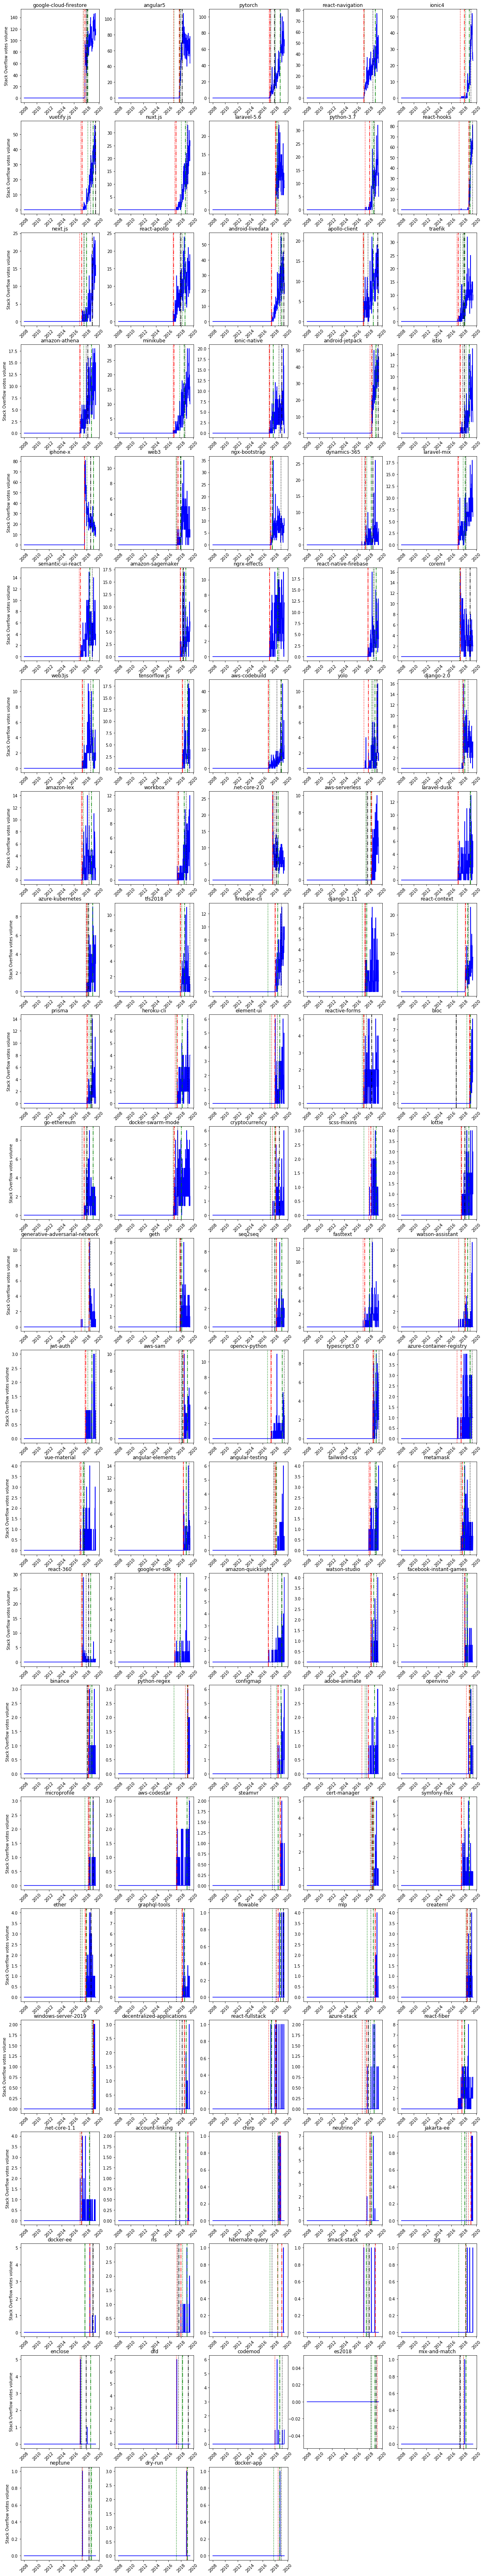

In [753]:
plot_trends_and_tags(after_warmup_tags_so_only.reset_index(), 
                     merged_both_after_warmup,
                     y1_label = 'Stack Overflow votes', date_col_name='date')

Okay, so that's how it is for tags that were created after the warmup period: the difference becomes very small, compared to the indisputable differences that we saw before. Let's take the time threshold for the tags further back and see what happens.

In [821]:
tags_not_so_old_but_not_so_new = merged_both_after_warmup.loc[
            merged_both_after_warmup.TagFirstUseDate > datetime(2015,10,1)].TagName.values

middle_aged_tag_adoption_sequences = \
    adoption_sequences.loc[adoption_sequences.TagName.apply(lambda x: x in tags_not_so_old_but_not_so_new)]

middle_aged_tag_adoption_sequences_agg = \
    middle_aged_tag_adoption_sequences[['TagName', 'short_adoption_seq']].groupby('short_adoption_seq').\
                    count().sort_values('TagName', ascending=False).reset_index()

(get_proportion_of_starting_element(middle_aged_tag_adoption_sequences_agg, 'short_adoption_seq', 'S'), 
 get_proportion_of_starting_element(middle_aged_tag_adoption_sequences_agg, 'short_adoption_seq', 'C'), 
 get_proportion_of_starting_element(middle_aged_tag_adoption_sequences_agg, 'short_adoption_seq', 'A'),
 len(tags_not_so_old_but_not_so_new))

(0.7743589743589744, 0.13846153846153847, 0.08717948717948718, 195)

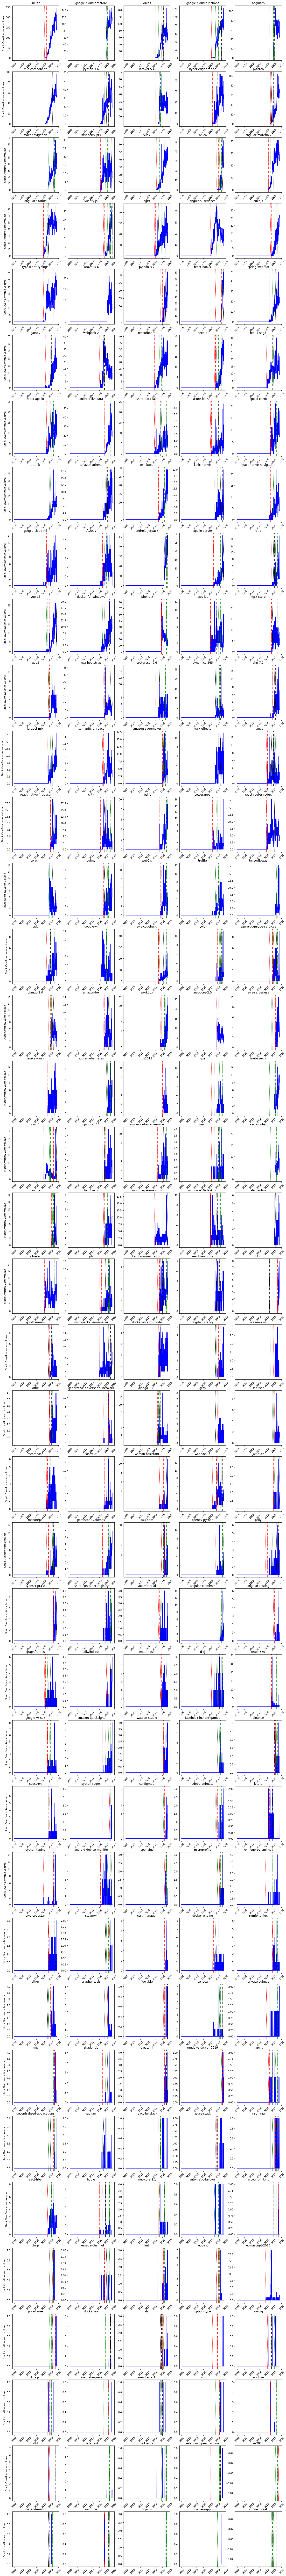

In [822]:
middle_aged_so_only=load_stack_overflow_trends(tags_not_so_old_but_not_so_new, 
                                               so_tag_index, so_week_index, so_timeseries,
                                                normalise = False)
plot_trends_and_tags(middle_aged_so_only.reset_index(), 
                     merged_both_after_warmup,
                     y1_label = 'Stack Overflow votes', date_col_name='date')

In [823]:
middle_aged_tag_adoption_sequences.describe()

SQ1_SQ5       SQ1_SV       SQ1_A1       A1_A5       SQ1_C1  \
count   183.000000   143.000000   195.000000  102.000000   195.000000   
mean    142.579235   277.664336   401.451282  210.705882   297.794872   
std     179.093668   241.448153   376.466372  164.783962   370.862493   
min       0.000000    -3.000000  -778.000000    0.000000  -711.000000   
25%      22.000000    94.000000   171.500000   90.000000    69.000000   
50%      73.000000   224.000000   409.000000  181.500000   322.000000   
75%     198.500000   391.000000   626.500000  286.500000   533.500000   
max    1032.000000  1180.000000  1326.000000  724.000000  1055.000000   

            C1_C5        SV_A1        SV_C1       A1_C1  
count  195.000000   143.000000   143.000000  195.000000  
mean   232.184615   172.573427    70.958042 -104.179487  
std    191.155107   372.841138   343.929138  312.086698  
min      0.000000  -889.000000  -560.000000 -985.000000  
25%     81.000000   -29.000000  -193.000000 -307.000000  
50%    192.000000   182.000000    55.000000 -127.000000  
75%    339.500000   384.500000   270.500000  124.500000  
max    859.000000  1255.000000  1052.000000  658.000000

In [829]:
middle_aged_course_ad_ordering = \
        calculate_ordering_proportion(middle_aged_tag_adoption_sequences_agg, 'short_adoption_seq', 'C', 'A')
middle_aged_course_ad_ordering

(0.6461538461538462, 195)

In [831]:
chisquare([int(middle_aged_course_ad_ordering[1]*middle_aged_course_ad_ordering[0]), 
           int(middle_aged_course_ad_ordering[1]*(1-middle_aged_course_ad_ordering[0]))]) 

Power_divergenceResult(statistic=16.661538461538463, pvalue=4.467771099432264e-05)

In [828]:
calculate_ordering_proportion(shortened_adoption_sequences, 'short_adoption_seq', 'C', 'A')

(0.6218354430379747, 632)

The further back we go, the greater the SO-first proportion. But even for Oct. 2015, the proportion is 77.78%, which is still far from 93%. So there is something going on here.

Maybe we could say that by limiting our tags to only those that were created after Oct. 2016, and given the common profile that we see (SQ1 comes way before C1 and A1), this is essentially limiting us to a _specific kind of tag_ that grows super fast, thus limiting the validity of our tags for the greater whole. Now the main question is the following: For courses and ads, we've limited ourselves to those that came out after Oct. 2016, but we haven't done so for Stack Overflow tags. Is this a valid thing to do, and how much does it bias us towards SQ1 coming way before C1 and A1? How can we prove that our results are not an artefact of this design choice?

We've partially proven that through our verification that our process seems to hold (for the most part) for tags created after the warmup period. Another way to verify this is to check separately for ads and MOOCs, each for their respective post-warmup period, so that we can confirm that SQ1 comes before A1 and C1 anyway. Let's do that now.

In [757]:
only_tags_and_ads_df = pd.merge(tag_first_use_so_df.loc[tag_first_use_so_df.TagFirstUseDate >= datetime(2016,10,1)], 
         tag_first_mentions_ads.loc[tag_first_mentions_ads.published >= datetime(2016,10,1)], 
         left_on='Tag', right_on='tag')
only_tags_and_ads_df['time_diff'] = only_tags_and_ads_df.apply(lambda x: 
                                           (x['TagFirstUseDate'] - x['published']).days, axis=1)
(only_tags_and_ads_df.time_diff < 0).sum() / only_tags_and_ads_df.shape[0], only_tags_and_ads_df.shape[0]

(0.671583087512291, 1017)

In [758]:
only_tags_and_courses_df = pd.merge(tag_first_use_so_df.loc[
         tag_first_use_so_df.TagFirstUseDate >= datetime(2014,10,1)], 
         tags_with_first_appearances.loc[tags_with_first_appearances.date >= datetime(2014,10,1)], 
         left_on='Tag', right_on='TagName')
only_tags_and_courses_df['time_diff'] = only_tags_and_courses_df.apply(lambda x: 
                                           (x['TagFirstUseDate'] - x['date']).days, axis=1)
(only_tags_and_courses_df.time_diff < 0).sum() / only_tags_and_courses_df.shape[0], only_tags_and_courses_df.shape[0]

(0.7399049881235155, 842)

Looks like we're in the clear. Even though Stack Overflow's precedence over ads and courses isn't as overwhelming as we'd believe if we only looked at the earlier numbers, at least we're sure that it _does_ precede them more than half the time and that this shit ain't random. Given this, our course of action is twofold:
1. Prove that the Stack Overflow-Google Trends pair does precede the MOOC-Ad pair, which we've essentially done above.
2. Go into the prediction side of things by setting an earlier starting date for Stack Overflow tags, such that we get to (try to) predict things for different types of tags while still taking care not to include the tags that are just ancient. Here, the important thing is to find a starting date for the tags that isn't just arbitrary.

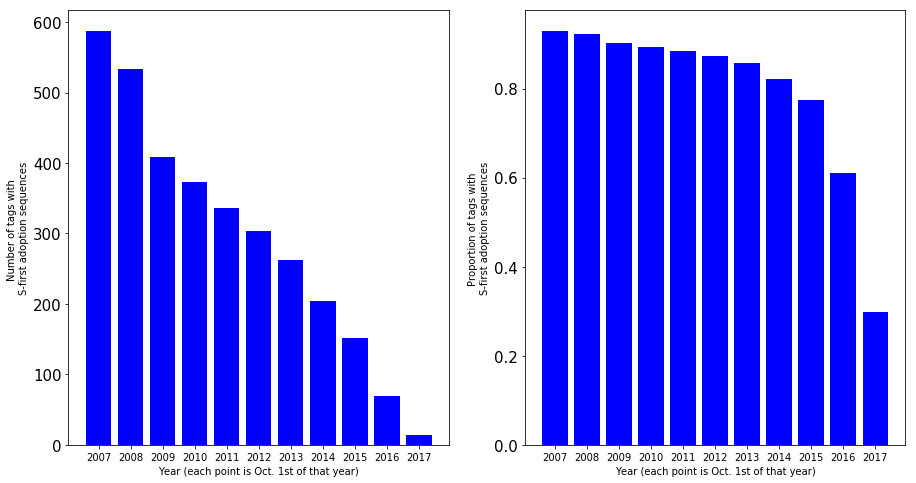

In [795]:
stackoverflow_start_proportions = list()
current_year_range = range(2007,2018)
for current_year in current_year_range:
    current_tags = merged_both_after_warmup.loc[
            merged_both_after_warmup.TagFirstUseDate > datetime(current_year,10,1)].TagName.values

    current_adoption_sequences = \
        adoption_sequences.loc[adoption_sequences.TagName.apply(lambda x: x in current_tags), 
                           ['TagName', 'short_adoption_seq']].groupby('short_adoption_seq').\
                        count().sort_values('TagName', ascending=False).reset_index()

    stackoverflow_start_proportions.append((get_proportion_of_starting_element(current_adoption_sequences, 
                               'short_adoption_seq', 'S'), len(current_tags)))

ax = plt.figure(figsize=(15,8))
ax1 = plt.subplot(1,2,1)
ax1.bar(x=list(current_year_range), height=[x[0]*x[1] for x in stackoverflow_start_proportions], color='blue')
ax1.set_ylabel('Number of tags with \nS-first adoption sequences')
ax1.set_xlabel('Year (each point is Oct. 1st of that year)')
ax1.set_xticks(list(current_year_range))
ax1.tick_params(axis='y', which='major', labelsize=15)
ax2 = plt.subplot(1,2,2)
ax2.bar(x=list(current_year_range), height=[x[0] for x in stackoverflow_start_proportions], color='blue')
ax2.set_ylabel('Proportion of tags with \nS-first adoption sequences')
ax2.set_xlabel('Year (each point is Oct. 1st of that year)')
ax2.set_xticks(list(current_year_range))
ax2.tick_params(axis='y', which='major', labelsize=15)
plt.show()

Actually, the fact that the number _and_ proportion go down considerably in 2016 and then 2017 can signify something important: first, that courses and ads may be getting more agile (especially courses), and second, that being so close to the edge means that only specific, very quick types of tags have had the time to get courses (especially since we're not limiting the courses/ads to that timeframe), meaning that the picture we see from 2017 is not a complete one. As such, 2016 provides a more balanced view. Let's not dismiss the first finding though, because it's interesting that it implies that the agility may be on the rise. Let's do a statistical test for 2015-2016, and also let's look at a comparison between 2016 and 2017 as the starting point for all data sources.

In [765]:
chisquare([int(stackoverflow_start_proportions[-2][1]*stackoverflow_start_proportions[-2][0]), 
           int(stackoverflow_start_proportions[-2][1]*(1-stackoverflow_start_proportions[-2][0]))],
          [int(stackoverflow_start_proportions[-3][1]*stackoverflow_start_proportions[-3][0]), 
           int(stackoverflow_start_proportions[-3][1]*(1-stackoverflow_start_proportions[-3][0]))])

Power_divergenceResult(statistic=44.5530571384568, pvalue=2.47556642646039e-11)

Yeah, the proportions for 2015 and 2016 are significantly different, so the later-created tags do seem to have a tendency to be more agile on the ad/course side. I guess the important question is whether this is just because at the 2015 point, the three starting points are still different, or if there's something else involved. At the very least we can observe the increased gap between 2015 and 2016, compared to the gaps for the years before them, and that could provide some support for the hypothesis that ads and courses are becoming more agile.

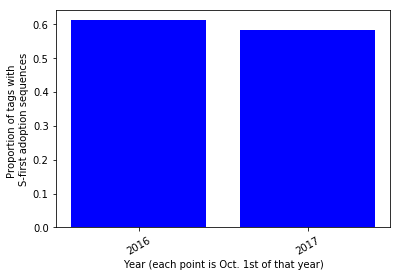

In [763]:
comparison_2016_2017 = list()
for current_year in [2016,2017]:
    current_tags = merged_both_after_warmup.loc[
            (merged_both_after_warmup.TagFirstUseDate > datetime(current_year,10,1)) & 
            (merged_both_after_warmup.ad_date > datetime(current_year,10,1)) &
            (merged_both_after_warmup.course_date > datetime(current_year,10,1))].TagName.values

    current_adoption_sequences = \
        adoption_sequences.loc[adoption_sequences.TagName.apply(lambda x: x in current_tags), 
                           ['TagName', 'short_adoption_seq']].groupby('short_adoption_seq').\
                        count().sort_values('TagName', ascending=False).reset_index()

    comparison_2016_2017.append((get_proportion_of_starting_element(current_adoption_sequences, 
                               'short_adoption_seq', 'S'), len(current_tags)))

plt.bar(x=[2016,2017], height=[x[0] for x in comparison_2016_2017], color='blue')
plt.ylabel('Proportion of tags with \nS-first adoption sequences')
plt.xlabel('Year (each point is Oct. 1st of that year)')
plt.xticks([2016,2017], rotation=30)
plt.show()

So apparently, moving that thing forward only slightly reduces the proportion, although the numbers are just much lower than 2016 so it's not that reliable. 

### Deprecated: Clustering

In [163]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=8)
excerpt_vectors = merged_both_after_warmup.ExcerptVec.values
kmeans_model.fit(list(excerpt_vectors))
merged_both_after_warmup['cluster_label'] = kmeans_model.labels_

In [97]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merged_both_after_warmup.sort_values('cluster_label'))

tag  \
438                         aws-ebs   
475                    aws-codestar   
38                            boto3   
136                   amazon-athena   
195          azure-stream-analytics   
75                       amazon-sns   
281                  aws-serverless   
246                   aws-codebuild   
185                         aws-iot   
387                         aws-sam   
546             aws-storage-gateway   
452                    redis-server   
380             elasticsearch-query   
238                azure-automation   
51                             xlsx   
485                             sld   
525               elasticsearch-api   
368             mongodb-replica-set   
115                 azure-data-lake   
532                    apex-trigger   
358                   image-caching   
172                          sparkr   
423                    natural-join   
415                     graphframes   
107                 apache-zeppelin   
103                         knex.js   
63                             dask   
382                              ff   
101                       shapefile   
389                          readxl   
217           hibernate-annotations   
411                        volusion   
511                     ddl-trigger   
72                        indexeddb   
196                  postgresql-9.6   
198                    dynamics-365   
208                        topojson   
400              facebook-analytics   
234         functional-dependencies   
536                            crdt   
431               amazon-quicksight   
334                   spatial-index   
288                             orc   
19                              hql   
446                          varray   
555                oracle-analytics   
456                        airtable   
559                      geopackage   
154         informatica-powercenter   
563                              h3   
8            google-cloud-datastore   
299                          arcmap   
324                        elastica   
3                     mongodb-query   
305                          prisma   
1            google-cloud-firestore   
10                 linq-to-entities   
568                   staging-table   
399              row-level-security   
25                          pymongo   
309                         geotiff   
545                        manifold   
348                  cryptocurrency   
276                      replicaset   
32                   azure-cosmosdb   
542              automatic-failover   
282             sql-server-profiler   
346               data-partitioning   
204                     grid-search   
502                             mlp   
473              kolmogorov-smirnov   
500                           siege   
135                           epoch   
464                        openvino   
144                    force-layout   
96                            spacy   
430                            deap   
159                 google-cloud-ml   
132                    scikit-image   
429                         dropout   
457                model-comparison   
463                           knuth   
120                             ode   
93                      tensorboard   
161                     autoencoder   
310                 hyperparameters   
83                         word2vec   
357  generative-adversarial-network   
360                         seq2seq   
36                             lstm   
367                        fasttext   
344                             mle   
30                          pytorch   
206                    data-fitting   
379                   mixture-model   
527                        kurtosis   
236                   tensorflow.js   
340                    quantization   
287                             pwm   
231                          coreml   
263                         p-value   
229           numerical-integration   
349            

## First ad counts for companies

In [766]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merged_both_after_warmup[['TagName', 'author']].groupby('author').count().sort_index())

TagName
author                                                     
                                                          1
(Poly)Swarm Technologies, Inc                             1
14 West                                                   1
14 West and The Agora Companies                           1
1MG Technologies Private Limited                          1
2U                                                        1
2degrees                                                  1
3Ci                                                       1
3D Hubs                                                   1
3D Systems Corporation                                    2
3Shape                                                    4
42 Lines, Inc.                                            1
47Lining, a Hitachi Vantara Company                       1
4impact                                                   2
7Summits                                                  1
AARON FORMACIÓN Y CONSULTORÍA                             1
ABAX                                                      1
ABLEVETS LLC                                              1
ABN AMRO Bank                                             2
ABOUT YOU GmbH                                            4
ACI Worldwide - PAY.ON AG                                 1
ACRIS E-Commerce GmbH                                     1
AECOM                                                     1
AIB                                                       1
AIC                                                       1
AIM Consulting Group                                      1
AIXTRON SE                                                1
AKA Enterprise Solutions                                  1
ALARZEL                                                   1
ALM First                                                 1
ALTEN TIC                                                 1
APN Software Services, Inc                                2
ARM                                                       1
ARS Computer und Consulting GmbH                          1
ASAP Services, LLC                                        1
ASCEND HIT                                                1
ASCII Group LLC                                           2
ASTRO Strobel Kommunikationssysteme GmbH                  1
AT&T Cybersecurity                                        1
ATHION GmbH                                               1
AURO NEW TRANSPORT CONCEPT SL.                            1
AUTO1                                                     2
AUTO1 Group GmbH                                          1
AVANSIS                                                   2
AVANTGARDE IT SERVICES SL.                                2
AVM Consulting Inc                                        2
Abilis Solutions                                          1
Above                                                     2
Acando                                                    2
Acceleration                                              1
Accenture                                                 7
Accenture The Dock                                        1
Accenture ofertas de profesionales con experien...        1
Aceable                                                   1
Acrolinx                                                  1
Acronis Asia Research and Development Pte Ltd             1
Act-On Software                                           1
Active Agent AG                                           1
ActiveState Software                                      1
Actyx AG                                                  1
AdClear GmbH                                              1
Adaptive Financial Consulting                             1
Addison Group                                             2
Addison Professional Financial Search LLC                 2
AdeptMind Inc.                                            3
Aditelsa                        

### Companies who have the first ad for both types of tags (ad-first and course-first)

In [767]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merged_both_after_warmup.loc[merged_both_after_warmup.difference_in_days.apply(lambda x: x > 0), ['author', 'TagName']].groupby('author').count().\
        join(merged_both_after_warmup.loc[merged_both_after_warmup.difference_in_days.apply(lambda x: x < 0), ['author', 'TagName']].groupby('author').count(), 
                     lsuffix='_ad_first', rsuffix='_course_first', how='inner').join(
            merged_both_after_warmup[['TagName', 'author']].groupby('author').count(), rsuffix='_total').
            sort_index().rename(columns={'TagName': 'total'}))

TagName_ad_first  \
author                                                           
3D Systems Corporation                                       1   
3Shape                                                       2   
4impact                                                      1   
ABN AMRO Bank                                                1   
ABOUT YOU GmbH                                               3   
APN Software Services, Inc                                   1   
AUTO1                                                        1   
AVANSIS                                                      1   
AVANTGARDE IT SERVICES SL.                                   1   
AVM Consulting Inc                                           1   
Above                                                        1   
Accenture                                                    3   
Addison Group                                                1   
Addison Professional Financial Search LLC                    1   
Adverity GmbH                                                1   
Albelli                                                      1   
Amazon                                                       2   
Amdocs                                                       2   
Apex Systems                                                 4   
Apple Inc.                                                   4   
Appy Health, INC                                             1   
Artis Consulting                                             1   
Auth0                                                        1   
Avionte Staffing Software                                    1   
Bento - B2B Robo Advisor                                     1   
Brooksource                                                  1   
CIKLUM IT SPAIN SL                                           1   
Comcast                                                      4   
Criteo                                                       1   
EAB                                                          1   
European Bioinformatics Institute (EMBL-EBI)                 1   
JP Morgan Chase                                              1   
Siemens                                                      1   

                                              TagName_course_first  total  
author                                                                     
3D Systems Corporation                                           1      2  
3Shape                                                           2      4  
4impact                                                          1      2  
ABN AMRO Bank                                                    1      2  
ABOUT YOU GmbH                                                   1      4  
APN Software Services, Inc                                       1      2  
AUTO1                                                            1      2  
AVANSIS                                                          1      2  
AVANTGARDE IT SERVICES SL.                                       1      2  
AVM Consulting Inc                                               1      2  
Above                                                            1      2  
Accenture                                                        4      7  
Addison Group                                                    1      2  
Addison Professional Financial Search LLC                        1      2  
Adverity GmbH                                                    1      2  
Albelli                                                          1      2  
Amazon                                                           1      3  
Amdocs                                                           1      3  
Apex Systems                                                     1      5  
Apple Inc.                                                       4      8  
Appy Health, INC                                               

In [768]:
merged_both_after_warmup.loc[merged_both_after_warmup.difference_from_tag_wiki < 0].shape[0], \
merged_both_after_warmup.loc[merged_both_after_warmup.difference_from_tag_first_use < 0].shape[0]

(101, 44)

In [832]:
len(merged_both_after_warmup['author'].unique())

522

So the companies aren't how you'd think: for example, Google doesn't even make an appearance in the ad first group. This indicates that there are many companies involved in this innovation and adoption of new technologies (or new versions of a technology) and it is not monopolised by the Big 4. These technologies are development-related and not things such as autonomous cars or whatever, so we can only make this statement about development technologies. Now we need to also add the date of the first use of that tag on Stack Overflow, in order to see which ones are _really_ new.

Text(0, 0.5, 'Count')

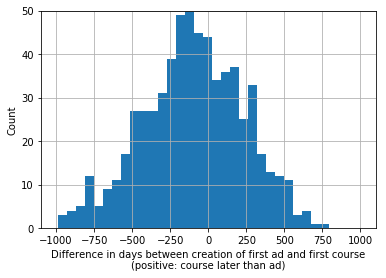

In [770]:
merged_both_after_warmup.difference_in_days.hist(bins=30)
plt.xlim([-1100,1100])
plt.ylim([0,50])
plt.xlabel('Difference in days between creation of first ad and first course\n(positive: course later than ad)')
plt.ylabel('Count')

## The tags that have either an ad or a course, but not both

In [771]:
merged = pd.merge(tag_first_mentions_ads.loc[tag_first_mentions_ads['published'] >= datetime(2016,10,1)], 
                  tags_with_first_appearances.loc[
                  tags_with_first_appearances['date'] >= datetime(2016,10,1)], 
                  left_on='tag', right_on='TagName', how='outer')\
                [['tag', 'TagName', 'author', 'published', 'date', 'TagCount', 'Excerpt', 'TagWikiDate']].rename(
                            columns={'published': 'ad_date', 'date': 'course_date'}).\
                            sort_values('TagCount', ascending=False)
merged = merged.loc[(merged.tag.apply(lambda x: pd.isnull(x))) | (merged.TagName.apply(lambda x: pd.isnull(x)))]
merged['TagName'] = merged.apply(lambda x: x['TagName'] if not pd.isnull(x['TagName']) else x['tag'], axis=1)
merged = merged.drop(columns=['tag'])
merged = pd.merge(merged, tag_first_use_so_df, left_on='TagName', right_on='Tag')
merged['difference_from_tag_first_use'] = merged.apply(lambda x: 
                          min([(x['course_date']-x['TagFirstUseDate']).days, 
                               (x['course_date']-x['ad_date']).days]) , axis=1)
merged['difference_from_tag_wiki'] = merged.apply(lambda x: 
                          min([(x['course_date']-x['TagWikiDate']).days, 
                               (x['course_date']-x['ad_date']).days]) , axis=1)

In [772]:
merged.head()

TagName author ad_date         course_date  TagCount  \
0             haskell    NaN     NaT 2017-01-10 09:23:55   41525.0   
1         cocoa-touch    NaN     NaT 2016-10-10 14:51:12   34598.0   
2  google-apps-script    NaN     NaT 2017-04-22 13:35:50   26092.0   
3        datagridview    NaN     NaT 2017-06-08 02:22:27   18300.0   
4              ffmpeg    NaN     NaT 2017-05-13 20:12:45   17486.0   

                                             Excerpt         TagWikiDate  \
0  Haskell is a functional programming language f... 2010-09-02 08:19:11   
1  The Cocoa Touch Frameworks that drive iOS apps... 2010-09-02 08:18:40   
2  Use for questions about Google Apps Script, Go... 2011-08-29 21:02:33   
3  The DataGridView is a Windows Forms control fo... 2011-03-02 13:20:10   
4  Only questions about programmatic use of the F... 2011-02-17 16:29:36   

                  Tag         TagFirstUseDate  difference_from_tag_first_use  \
0             haskell 2008-08-05 14:16:02.720                         3079.0   
1         cocoa-touch 2008-08-14 09:51:06.207                         2979.0   
2  google-apps-script 2009-05-29 04:05:30.687                         2885.0   
3        datagridview 2008-09-07 09:28:23.023                         3195.0   
4              ffmpeg 2008-09-04 14:35:14.437                         3173.0   

   difference_from_tag_wiki  
0                    2322.0  
1                    2230.0  
2                    2062.0  
3                    2289.0  
4                    2277.0

In [773]:
group3_so_only=load_stack_overflow_trends(merged.head(30).TagName.values, 
                                               so_tag_index, so_week_index, so_timeseries,
                                                normalise = False)

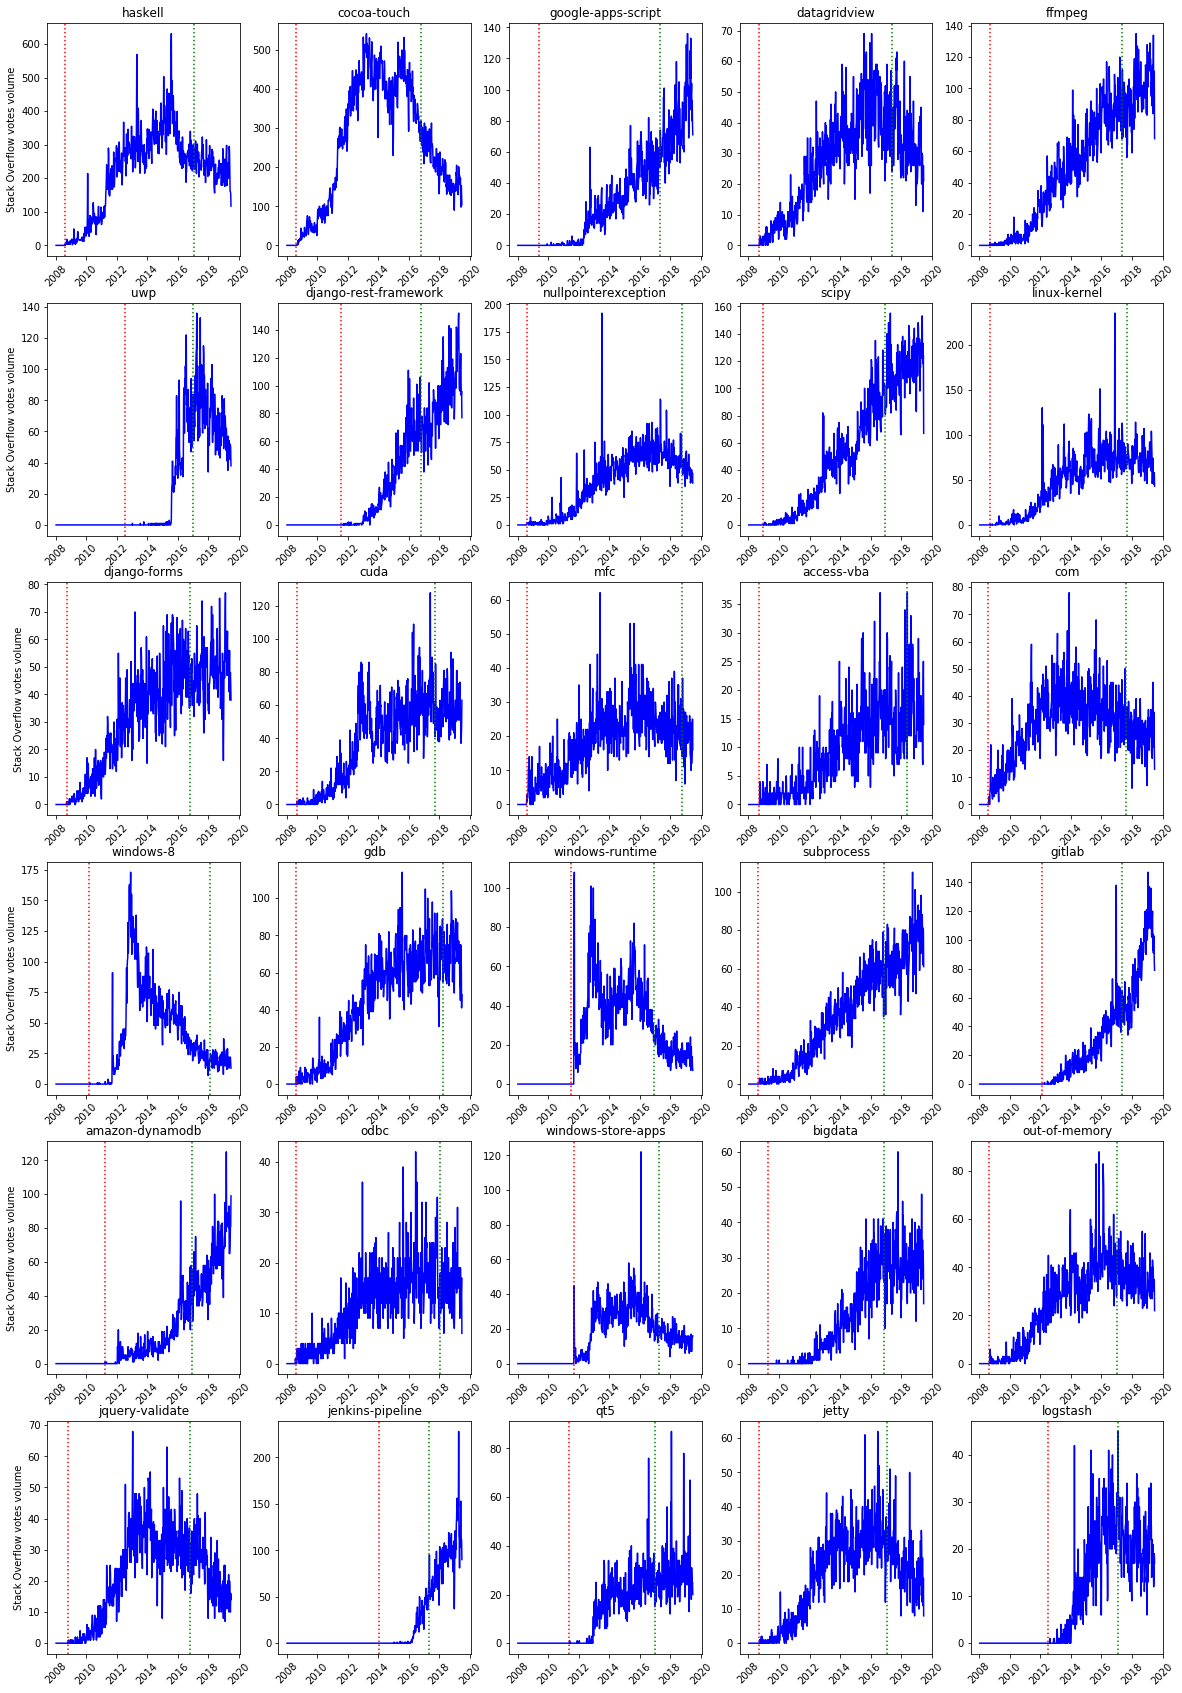

In [774]:
plot_trends_and_tags(group3_so_only.reset_index(), 
                     merged,
                     y1_label = 'Stack Overflow votes', date_col_name='date')

### Number of tags with only a course or ad, and tags with both

In [775]:
{'Only course': merged.loc[merged.ad_date.apply(pd.isnull)].shape[0], 
 'Only ad': merged.loc[merged.course_date.apply(pd.isnull)].shape[0], 
 'Both': merged_both_after_warmup.shape[0],
 'Total': merged.shape[0]}

{'Only course': 1544, 'Only ad': 6704, 'Both': 632, 'Total': 8248}

So out of all the tags, most of them actually do get an ad. Of course, when we wanna simultaneously analyse SO, MOOCs and ads, we need to use the joint thingy, but still it's interesting.

## Investigating the most popular tags _without_ courses or ads

In [776]:
tags_with_course_or_ad = set(tags_with_first_appearances.tag_name.values).\
                                union(set(tag_first_mentions_ads.tag.values))

In [777]:
ad_and_courseless_tags = tags_with_counts.loc[tags_with_counts.apply(lambda x: x['CreationDate'] > datetime(2016,10,1) 
                                    and x['TagName'] not in tags_with_course_or_ad, axis=1)].\
                                    sort_values('TagCount', ascending=False)
ad_and_courseless_tags = pd.merge(ad_and_courseless_tags, tag_first_use_so_df, 
                                  left_on='TagName', right_on='Tag').drop(columns=['Tag'])

ad_and_courseless_tags.shape[0], \
ad_and_courseless_tags.loc[ad_and_courseless_tags.TagCount > 200].shape[0] / ad_and_courseless_tags.shape[0],\
ad_and_courseless_tags.loc[ad_and_courseless_tags.TagCount > 100].shape[0] / ad_and_courseless_tags.shape[0]

(5129, 0.04523298888672256, 0.11522713979333203)

In [778]:
ad_and_courseless_tags.loc[ad_and_courseless_tags.TagCount > 200]

Id  TagCount                           TagName  \
0    126437      3651                    pandas-groupby   
1    129310      2026                        discord.js   
2    124500      1928              hyperledger-composer   
3    132090      1912                    flutter-layout   
4    123178      1710                   vscode-settings   
5    126378      1703                        discord.py   
6    129390      1591               google-colaboratory   
7    122493      1585                           yarnpkg   
8    135235      1470             google-sheets-formula   
9    120197      1132             angular2-nativescript   
10   123425      1031                  google-app-maker   
11   123174      1023                    firebase-admin   
12   120151       983  azure-pipelines-release-pipeline   
13   136539       956                       laravel-5.8   
14   125539       925             react-native-flatlist   
15   128819       919               tensorflow-datasets   
16   128065       904                angular-httpclient   
17   123520       889                  laravel-eloquent   
18   130435       881       mfmailcomposeviewcontroller   
19   130463       860                     numpy-ndarray   
20   123841       857                               cv2   
21   122657       848              bottomnavigationview   
22   133192       822                      macos-mojave   
23   131038       819                kubernetes-ingress   
24   125451       799                     google-fabric   
25   115965       760             laravel-query-builder   
26   126118       709              google-assistant-sdk   
27   130780       694                     webdriverwait   
28   122654       690                         typo3-8.x   
29   121276       686              angular2-observables   
..      ...       ...                               ...   
202   33812       220                string-aggregation   
203  128802       218                    silverstripe-4   
204  131296       218              spring-cloud-gateway   
205  122259       218                 spring-boot-admin   
206   97704       217                    pre-signed-url   
207  127104       217                         formarray   
208  127035       213                     spring-config   
209  120783       213                         npm-start   
210  125483       212                      gravityforms   
211   34848       212                   eventaggregator   
212   44761       212                 temporary-objects   
213   57788       212                          subshell   
214  125258       211                        aws-sdk-js   
215  128134       211                           pyarrow   
216  120923       210                             yaxis   
217  119488       209               webpack-file-loader   
218  115096       208                       laravel-4.2   
219  129560       207                          xcode9.2   
220   20239       206                          httplib2   
221   53260       205               notificationmanager   
222  125738       205                cordova-plugin-fcm   
223  118191       205                         skiasharp   
224  126635       205                         shinyapps   
225   43648       204                  setwindowshookex   
226  124687       204                       ag-grid-ng2   
227   12319       204                 printing-web-page   
228  130390       203         postman-collection-runner   
229  133355       202                     postgresql-11   
230  115352       201                 template-literals   
231  122849       201         woocommerce-subscriptions   

                                               Excerpt        CreationDate  \
0    To be used for grouping variables together bas... 2017-08-19 19:41:47   
1    Discord.js is a node.js module that allows the... 2017-10-26 09:54:11   
2    Hyperledger Composer (previously Fabric Compos... 2017-02-03 12:11:18   
3    Layouts in Flutter, a mobile appl

In [781]:
group2_so_only=load_stack_overflow_trends(ad_and_courseless_tags.head(30).TagName.values, 
                                               so_tag_index, so_week_index, so_timeseries,
                                                normalise = False)

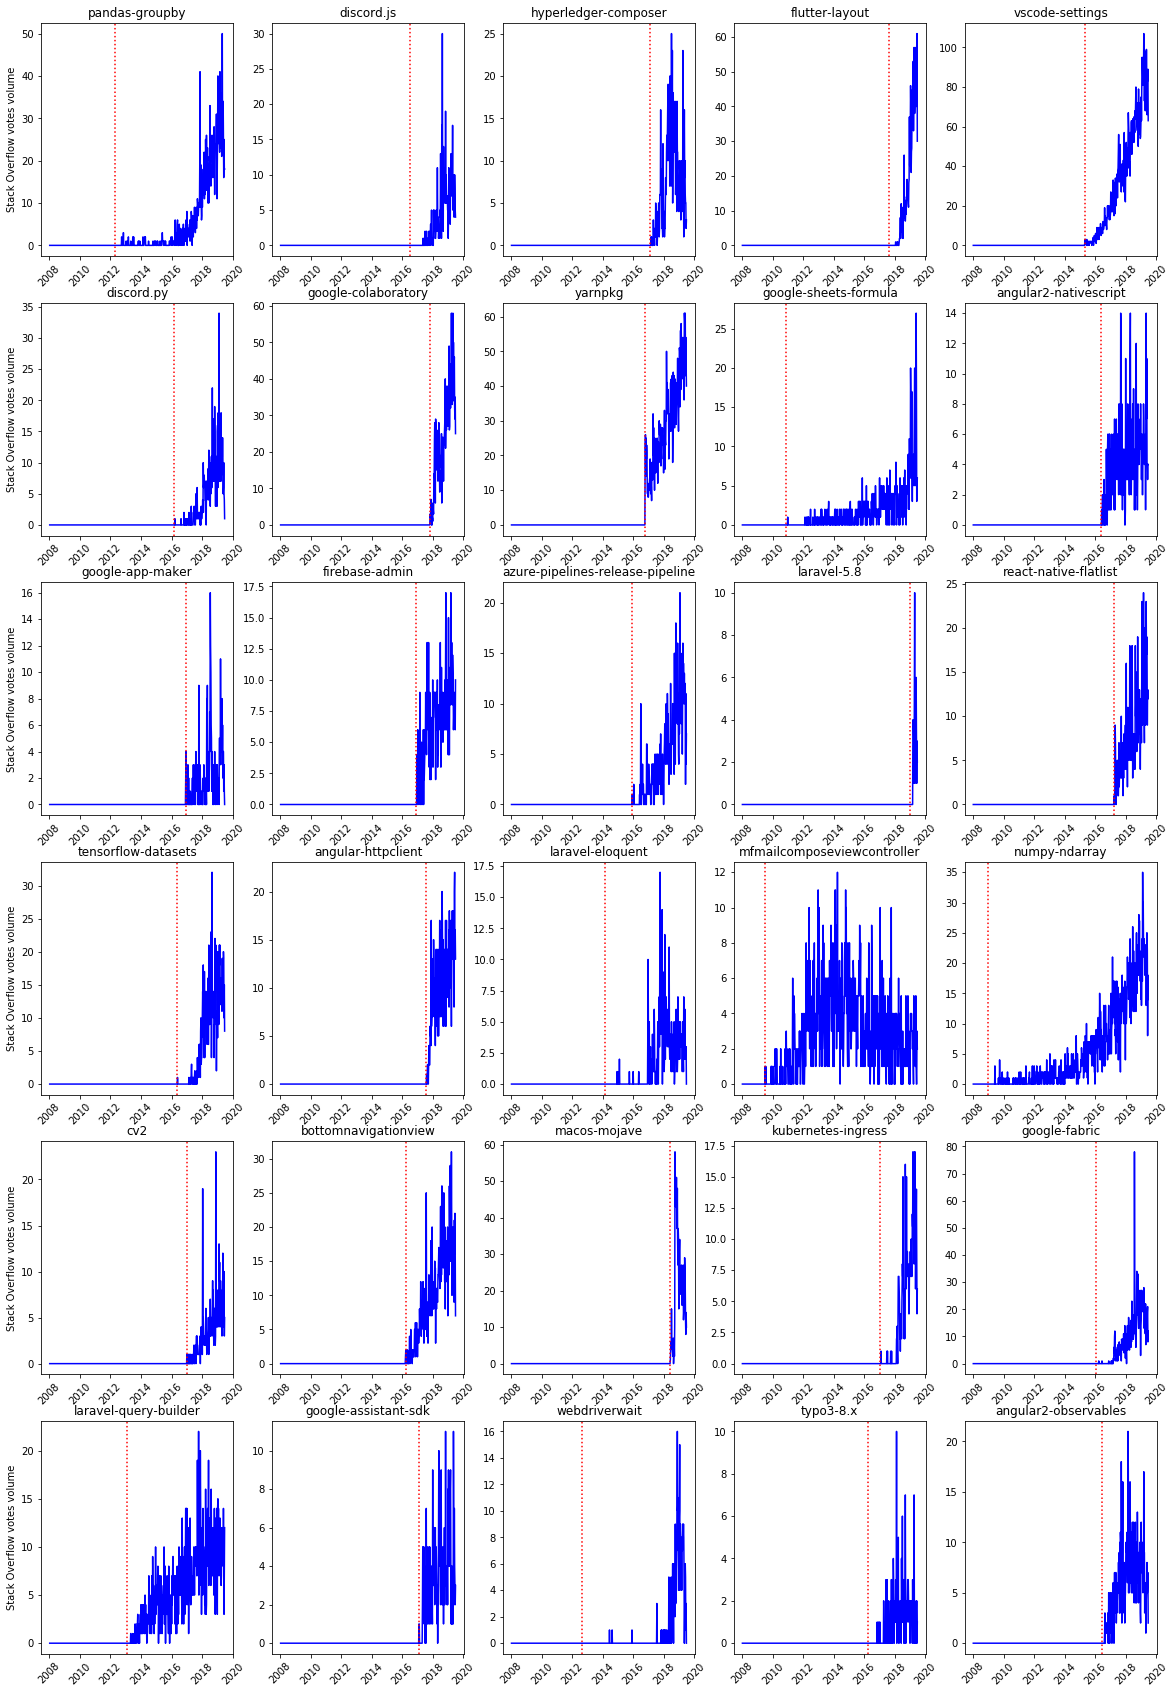

In [782]:
plot_trends_and_tags(group2_so_only.reset_index(), 
                     ad_and_courseless_tags,
                     y1_label = 'Stack Overflow votes', date_col_name='date')

So, bottom line from observing these:
* Many of these tags that seem to have gotten a course earlier than they got an ad are nonsensical tags like loop, Firefox, etc. Thus, we will either have to:
    * Hand pick the tags that we use, in order to avoid this entirely.
    * Use tags extracted from ad summaries to avoid missing out on these words.
    * Use a time lower bound on both or at least on courses. I dunno which one makes more sense.
    
Now, another important point is that sometimes, the exact matching of tags may prove problematic. Maybe some earlier ad, was related/relevant to this tag, but it simply didn't show up as our first ad for the tag because it didn't have the exact tag. There are three ways to deal with this:

* Leave it be, and then gauge the effect it could have on our method and the validity of our results.
* Extract tags also from the text of the ads. This still requires an assessment of the impact of potential unmatches on result validity.
* Cluster the tags beforehand (perhaps using Stack Overflow question data, or maybe using their descriptions), such that each ad or course gets matched to a cluster of tags, thus reducing the chance of an unmatch. The clusters would have to be very small, and mostly hierarchical (maybe we should simply deduce a tag hierarchy using the tags themselves?).

Regarding the third solution, i.e. clustering, there are two possibilities:

* Pre-clustering: The idea discussed above. We cluster the tags together, rather minimally, to reduce the risk of unmatches. This clustering is more along the lines of making sure that if tag x is mentioned in an ad/course, then all the technologies that would _always_ go with x are also matched to the ad/course. This means that if something has the tag `pyspark`, then it needs to have the tag `spark` as well; in other words, if a course is about PySpark, we would consider it to be about Spark too, and if an ad requires the applicant to have knowledge of PySpark, then it requires them to also have knowledge about Spark. Makes sense to some degree, but could also be questioned on the grounds of an indirect association. The association is a bit stronger in the case of job ads than in the case of courses.
* Post-clustering: Clustering tags together after the matching and the calculation of deltas. This is in order to group together similar tags and investigate those similarities and whether there are groups of tags that fall mostly into exactly one of the "ad before course" and "course before ad" classes. What we cluster them by is a matter of question: we could cluster them based on semantic similarity of the tags, but we could alternatively cluster them by the companies posting the first ads about them. We need to investigate various features of these tags (e.g. the two I mentioned) and see which features are most discriminative.
    * When I talk about "falling mostly into exactly one group", we need to be careful how we examine it. For example, if there are 5 deep learning related tags and 3 fall into "ad before course", then we have a lot of uncertainty and we cannot say that as a rule, deep learning-related tags have ads before courses. We really need to have the majority of them fall into the same class. Also, clusters with few members might not have enough for a meaningful categorisation, while members of larger clusters are likely not to fall into the same class at all.

It is possible for us to do both the pre-clustering and the post-clustering, since they are semantically and methodologically different. We will do the pre-clustering using simple heuristics, while the post-clustering will involve common techniques like k-means.